In [1]:
import pandas as pd
from glob import glob
import math
import numpy as np
from skimage import io, morphology, img_as_ubyte, img_as_float, filters
import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from shapely.geometry import LineString, MultiPoint
from shapely.ops import split
from scipy import io as sio
from centerline import CenterLine, smooth_mask, iou
import colorsys

### Create centerlines from masks

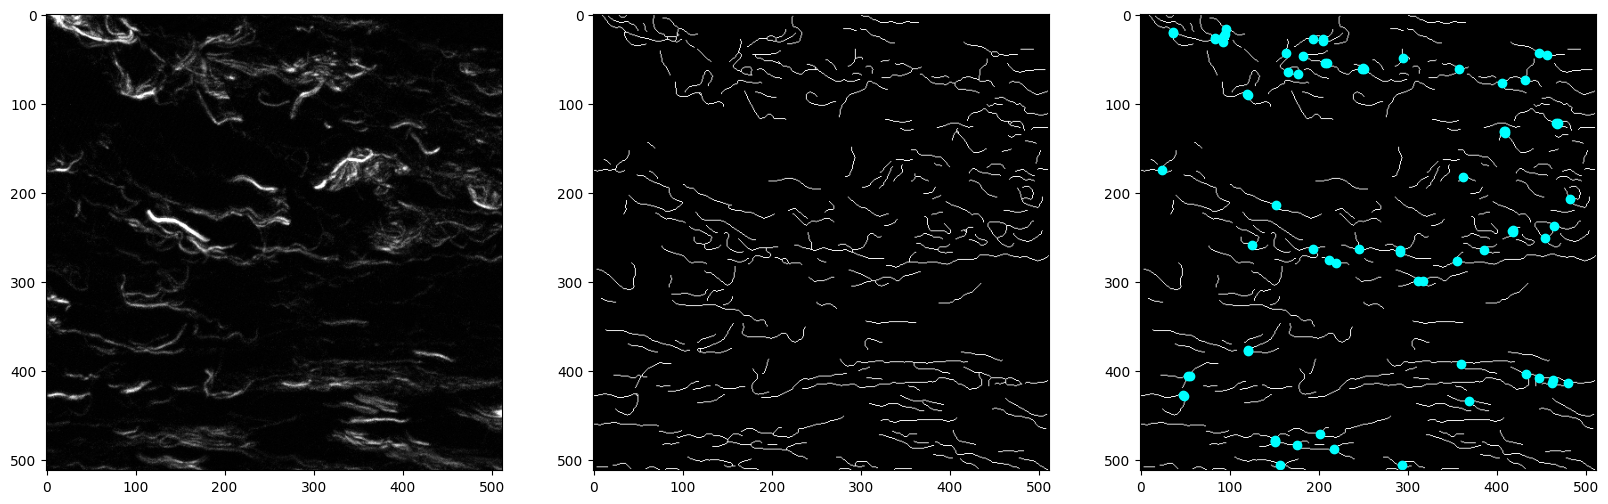

In [2]:
centerline = CenterLine(centerline_image=io.imread("examples/example_centerline.png"), associate_image=io.imread("examples/example_image.tif")) #
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline.joint_filter(centerline.centerline_image)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()

### Create centerline from dataframe (such as from output of ridge detetion plugin in FIJI)

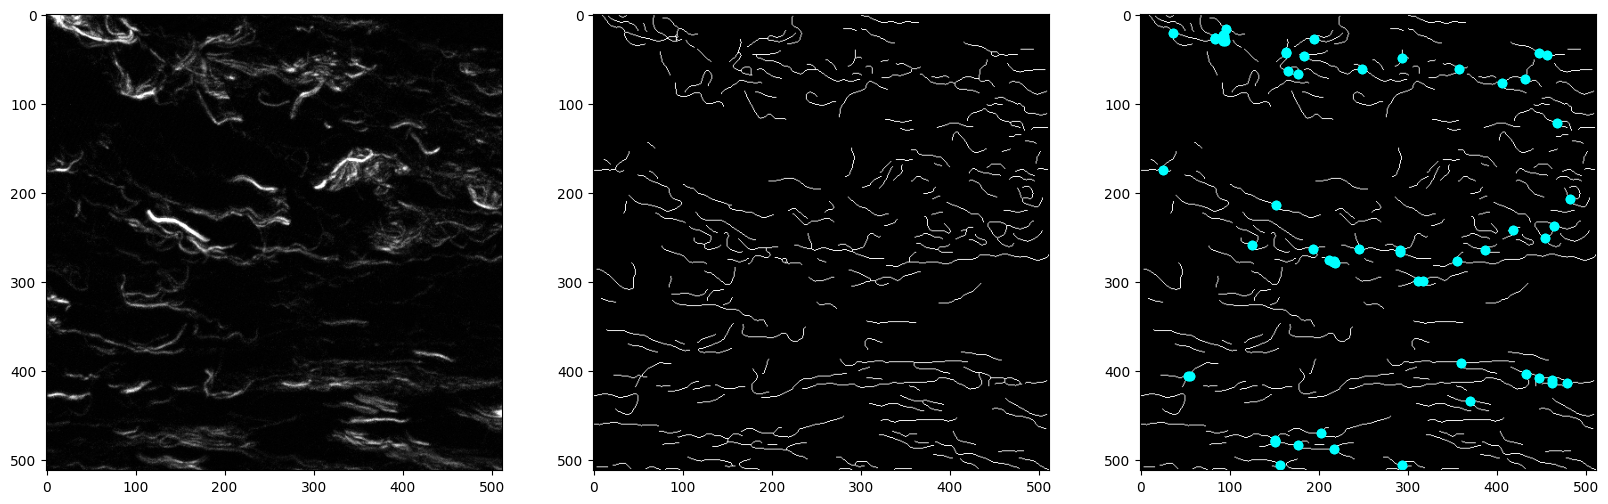

In [3]:
centerline = CenterLine(dataframe=pd.read_csv("examples/example_annotations.csv", index_col=0), associate_image=io.imread("examples/example_image.tif"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline.joint_filter(centerline.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()

### Create centerline from line_dict object

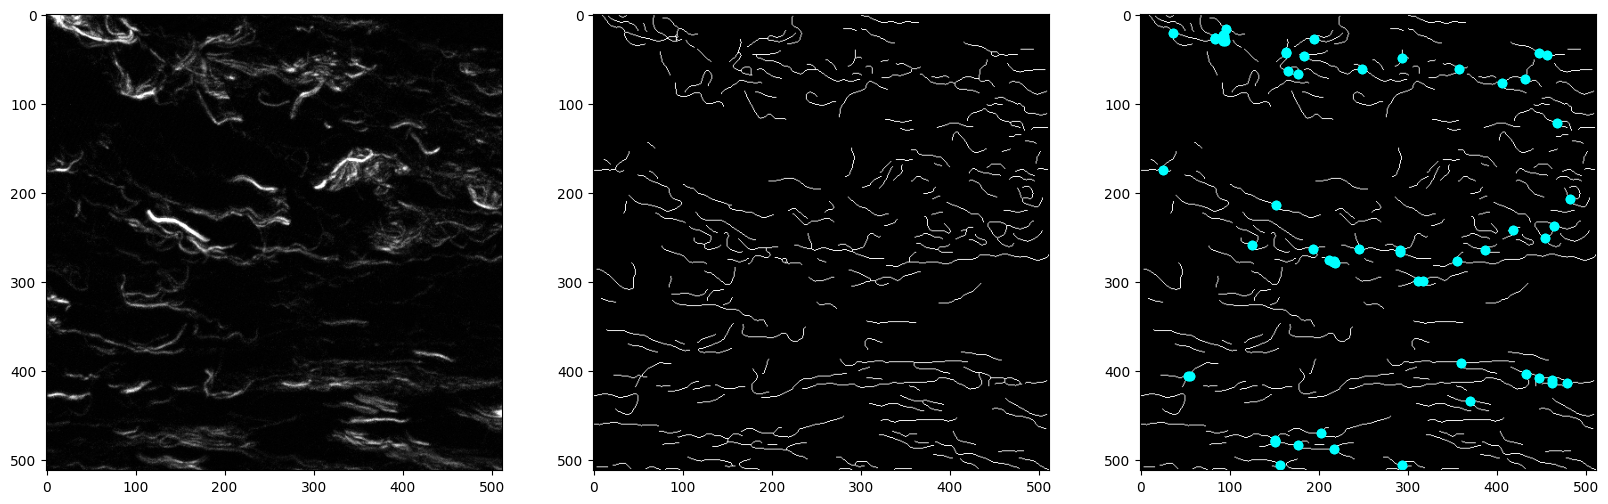

In [4]:
line_dict = centerline.line_dict
centerline = CenterLine(line_dict=line_dict, associate_image=io.imread("examples/example_image.tif"))
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(centerline.associate_image, cmap=plt.cm.gray)
ax[1].imshow(centerline.centerline_image, cmap=plt.cm.gray)
joints_coords, filtered_image = centerline.joint_filter(centerline.centerline_image)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax[2].imshow(filtered_image, cmap=plt.cm.gray)
ax[2].plot(joints_coords[:, 1], joints_coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
plt.show()

### Compute centerline features using centerline_image

In [5]:
centerline = CenterLine(centerline_image=io.imread("examples/example_centerline.png"), associate_image=io.imread("examples/example_image.tif"))
centerline.compute_fiber_feats() 
print(dict(list(centerline.feats.items())[:-1]))

{'cir_mean': -0.04554560616608039, 'cir_var': 0.5961450745451661, 'len_mean': 34.84375, 'len_var': 28.677978987275985, 'waviness': 0.3607832149304257, 'intensity': 7891}


### Compute centerline features using dataframe

In [6]:
centerline = CenterLine(dataframe=pd.read_csv("examples/example_annotations.csv", index_col=0), associate_image=io.imread("examples/example_image.tif"))
centerline.compute_fiber_feats() 
print(dict(list(centerline.feats.items())[:-1]))

{'cir_mean': -0.08156153750403283, 'cir_var': 0.6026662736301828, 'len_mean': 36.68544600938967, 'len_var': 30.02142622049813, 'waviness': 0.36283383034386185, 'intensity': 7779}


### Measure the similarity of two centerline (masks)

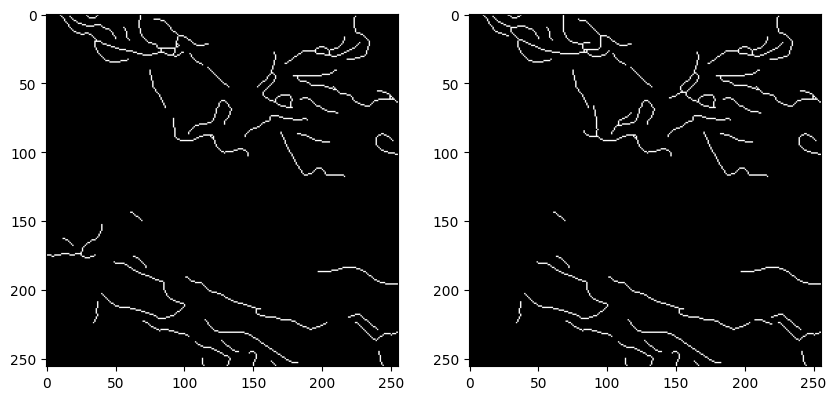

In [7]:
### any two centerline masks
image_1 = io.imread('examples/Annotation_Michael.tif')
image_2 = io.imread('examples/Annotation_Bin.tif')
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image_1, cmap='gray')
ax[1].imshow(image_2, cmap='gray')

0.7928515653288247


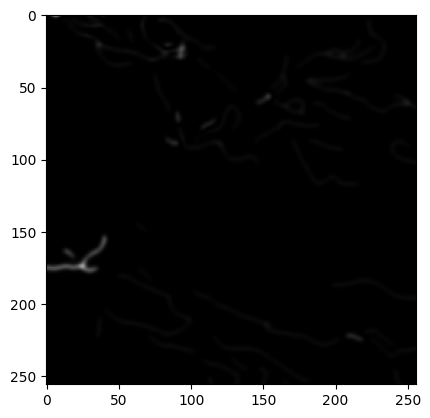

In [8]:
### Pixel-level metrics, soft IoU
ratio, U, I = iou(smooth_mask(image_1), smooth_mask(image_2), soft=True)
plt.imshow(U-I, cmap='gray')
print(np.sum(I)/np.sum(U))

### Create overlay results

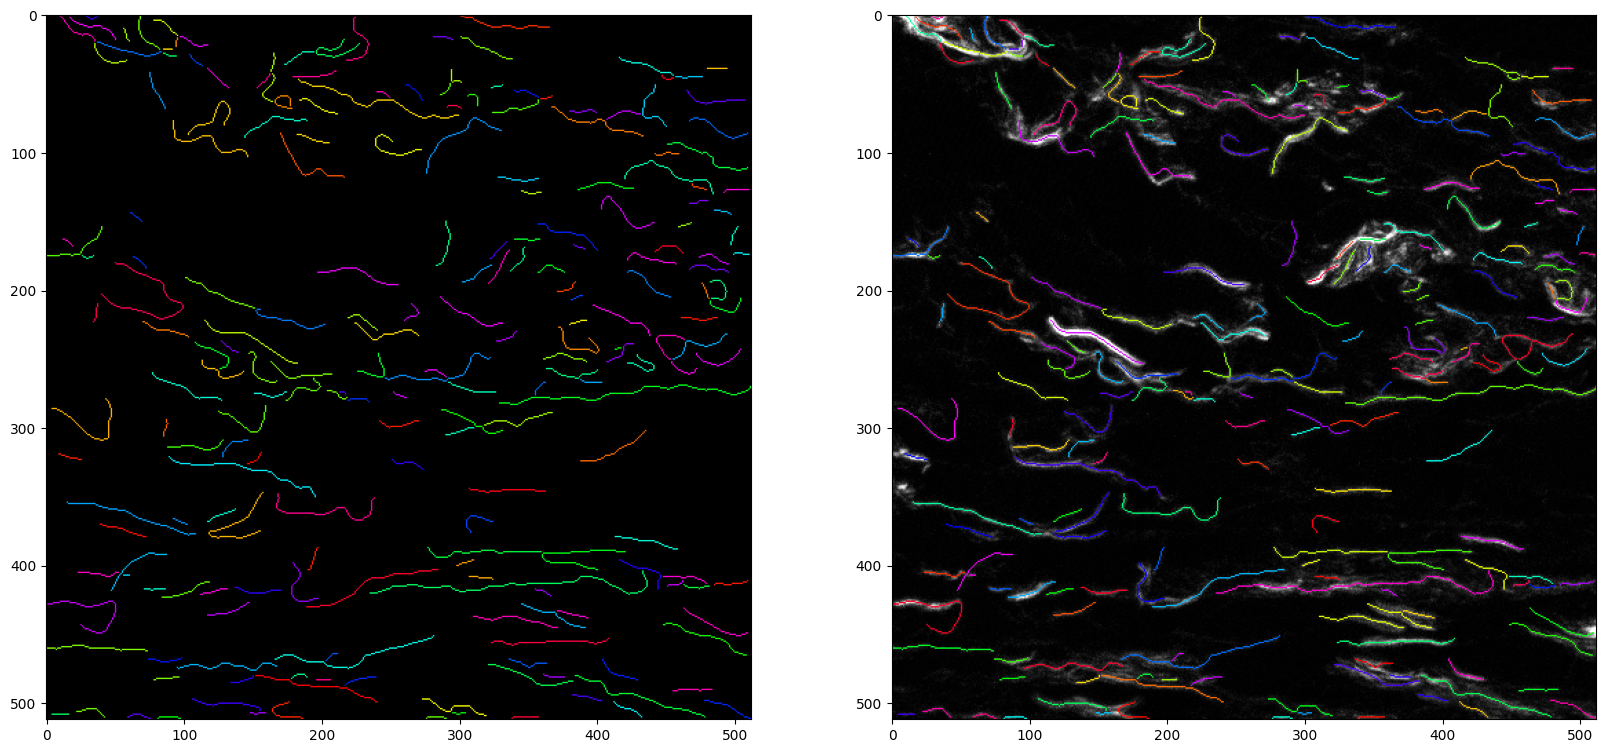

In [9]:
im_arr = io.imread('examples/example_image.tif')
## instance masks
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
centerline_res = CenterLine(centerline_image=centerline.centerline_image, associate_image=im_arr)
canvas = np.ones((centerline_res.image_size[0], centerline_res.image_size[1], 3), np.uint8) * 0
line_dict = centerline_res.line_dict
for k, v in line_dict.items():
    points = v.points
    image = np.zeros((512, 512), np.uint8)
    image = centerline_res.draw_line(points, image)
    (r, g, b) = colorsys.hsv_to_rgb(np.random.uniform(0, 1), 1.0, 1.0)
    R, G, B = int(255 * r), int(255 * g), int(255 * b)
    canvas[np.where(image>0)] = np.array([R, G, B])
ax[0].imshow(canvas)

### overlay
canvas = img_as_ubyte(np.repeat(im_arr[:, :, np.newaxis], 3, axis=2))
line_dict = centerline_res.line_dict
for k, v in line_dict.items():
    points = v.points
    image = np.zeros((512, 512), np.uint8)
    image = centerline_res.draw_line(points, image)
    (r, g, b) = colorsys.hsv_to_rgb(np.random.uniform(0, 1), 1.0, 1.0)
    R, G, B = int(255 * r), int(255 * g), int(255 * b)
    canvas[np.where(image>0)] = np.array([R, G, B])
ax[1].imshow(canvas)
plt.show()

### Print individual fiber results

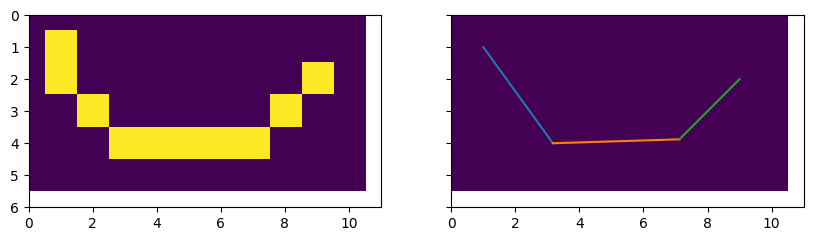

Length: 10.00, Waviness: 0.6595 



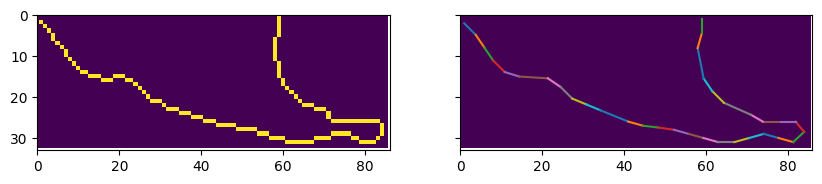

Length: 129.00, Waviness: 0.4596 



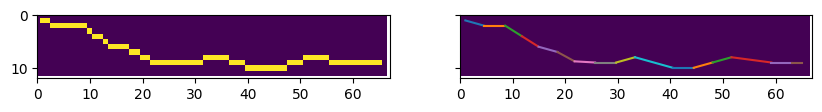

Length: 65.00, Waviness: 0.2891 



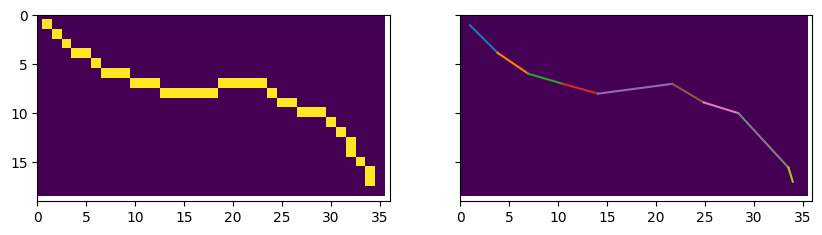

Length: 36.00, Waviness: 0.3739 



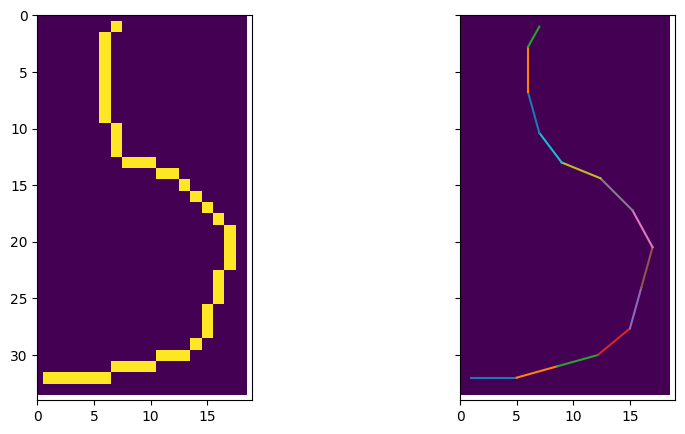

Length: 45.00, Waviness: 0.4653 



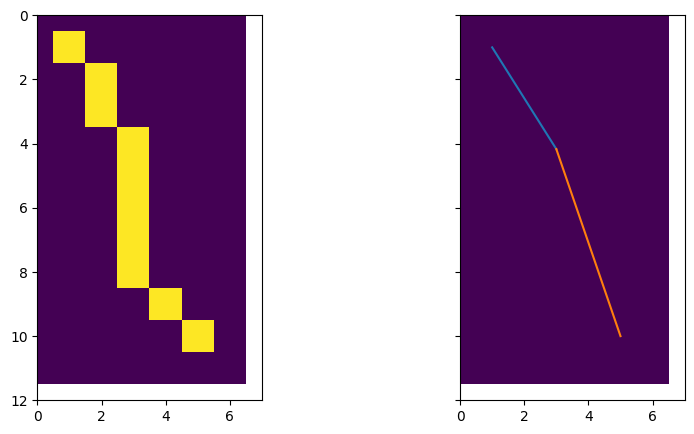

Length: 10.00, Waviness: 0.2943 



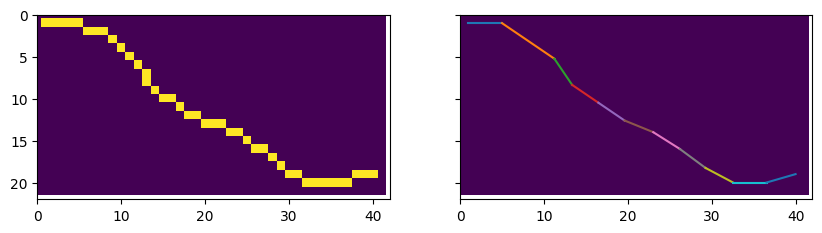

Length: 41.00, Waviness: 0.3366 



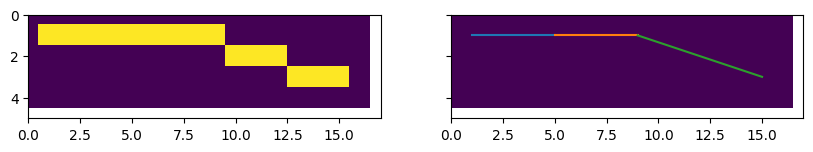

Length: 15.00, Waviness: 0.1686 



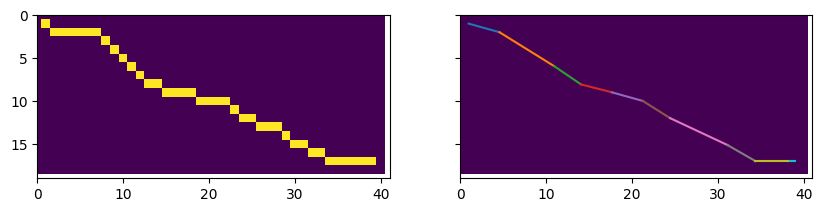

Length: 39.00, Waviness: 0.3263 



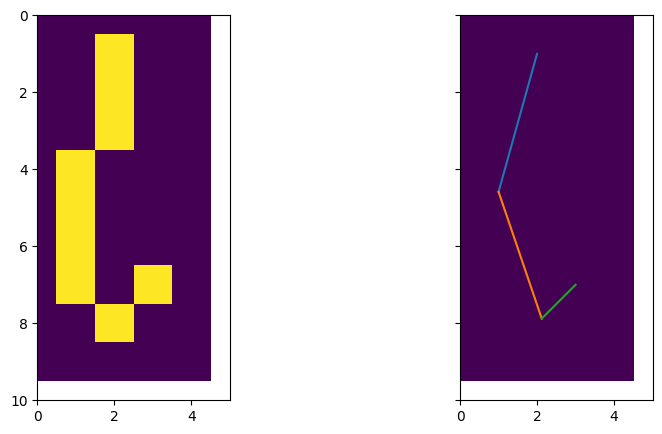

Length: 9.00, Waviness: 0.8867 



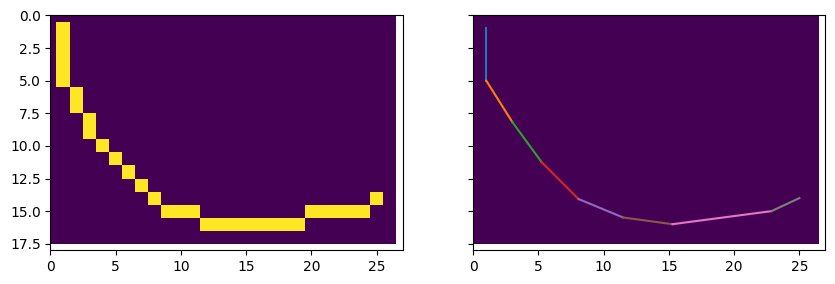

Length: 31.00, Waviness: 0.2948 



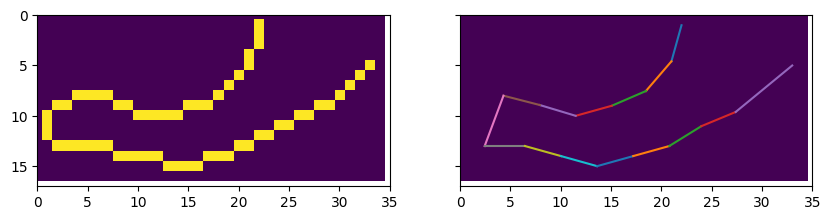

Length: 59.00, Waviness: 0.6819 



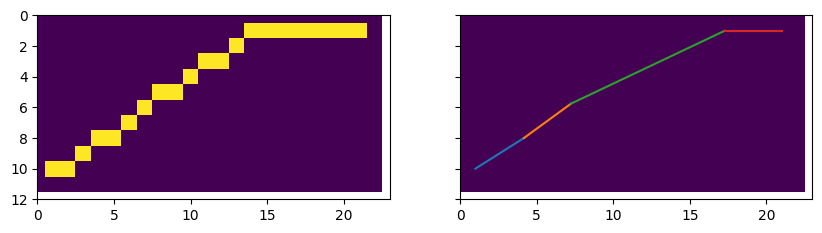

Length: 21.00, Waviness: 0.3255 



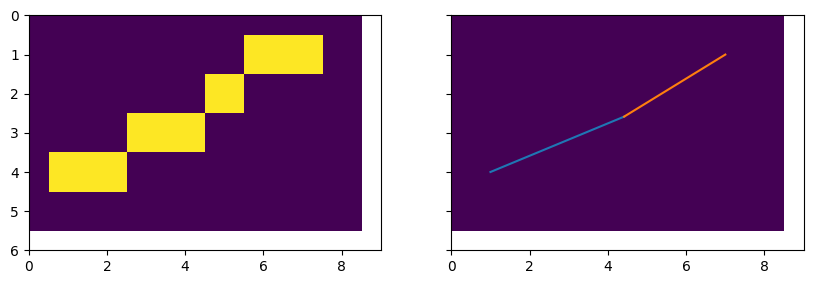

Length: 7.00, Waviness: 0.2869 



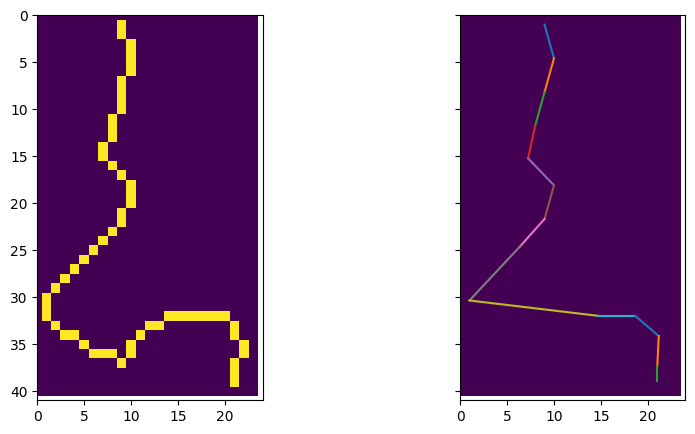

Length: 59.00, Waviness: 0.7956 



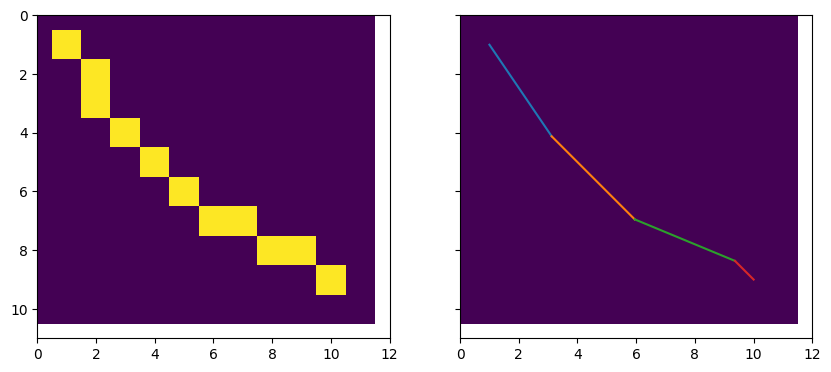

Length: 11.00, Waviness: 0.2715 



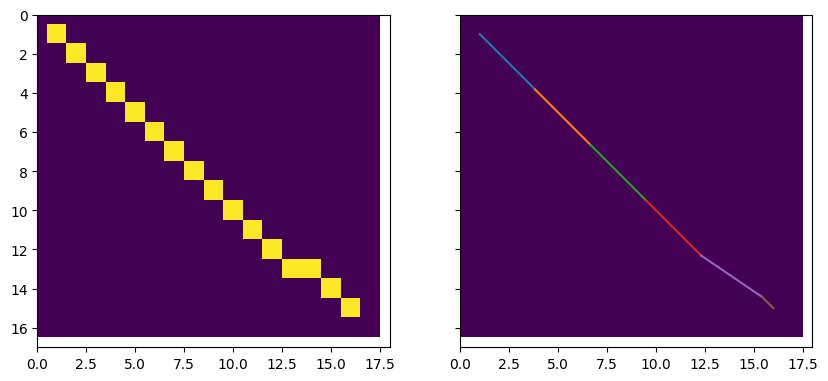

Length: 16.00, Waviness: 0.0714 



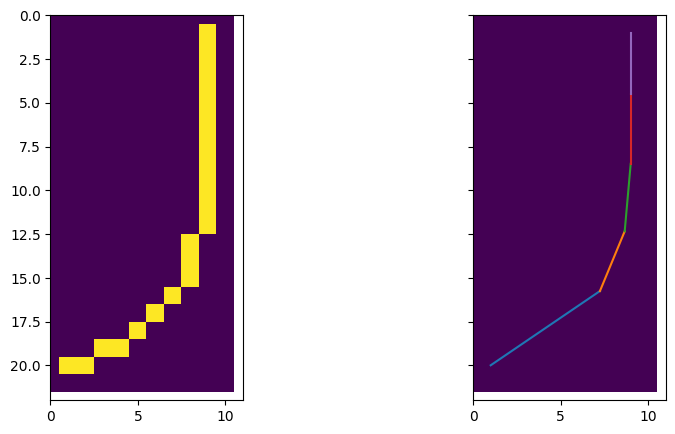

Length: 22.00, Waviness: 0.2552 



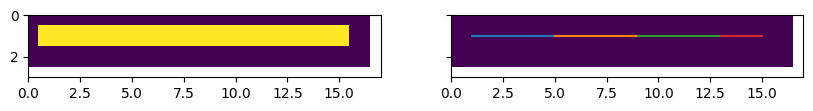

Length: 15.00, Waviness: 0.0000 



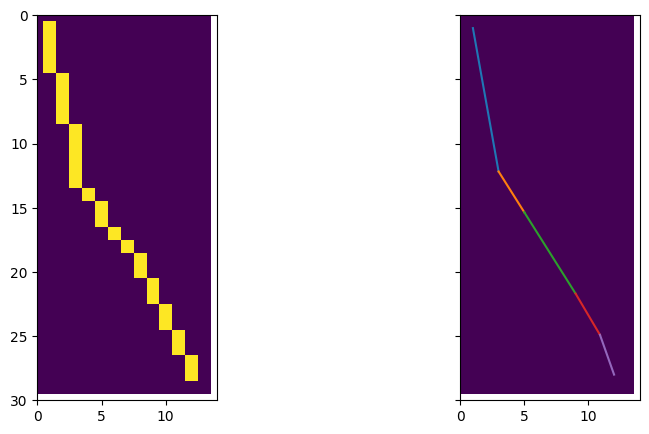

Length: 28.00, Waviness: 0.3228 



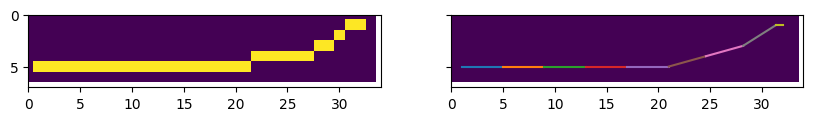

Length: 32.00, Waviness: 0.1630 



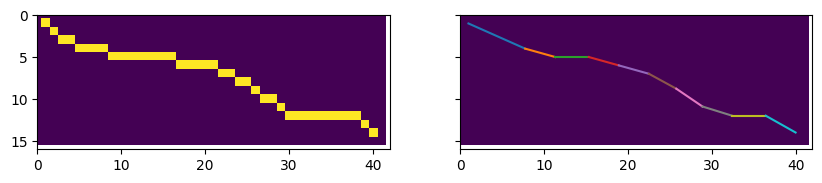

Length: 40.00, Waviness: 0.3127 



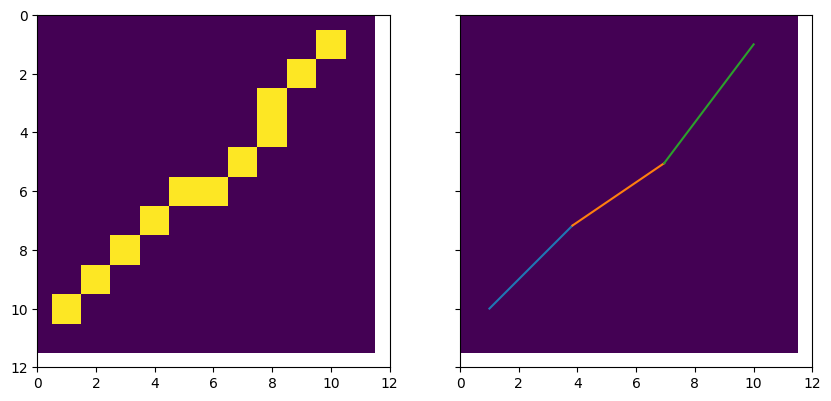

Length: 11.00, Waviness: 0.2120 



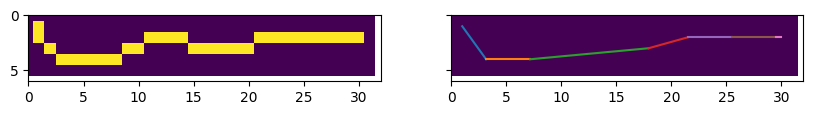

Length: 31.00, Waviness: 0.3017 



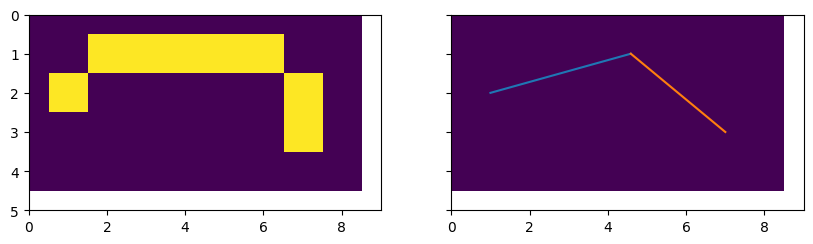

Length: 8.00, Waviness: 0.7124 



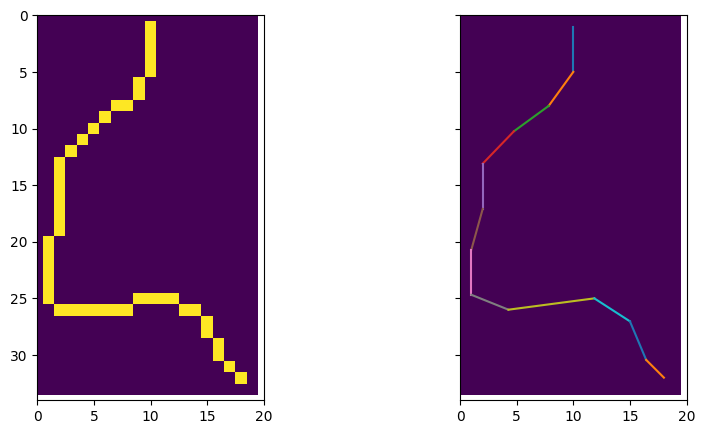

Length: 45.00, Waviness: 0.4948 



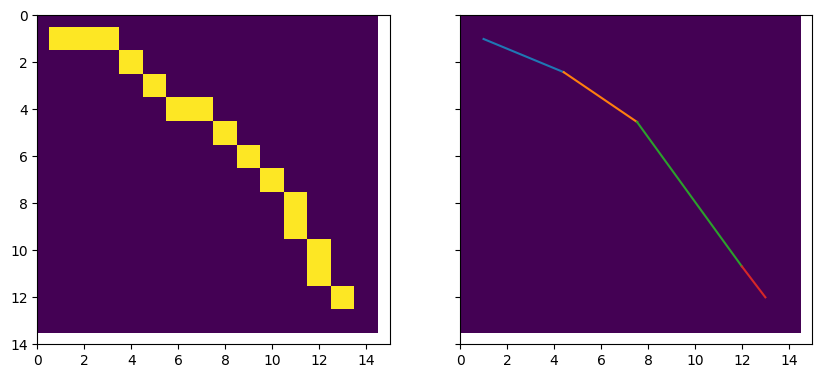

Length: 15.00, Waviness: 0.3129 



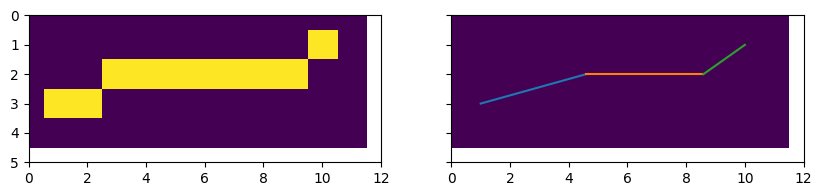

Length: 10.00, Waviness: 0.2504 



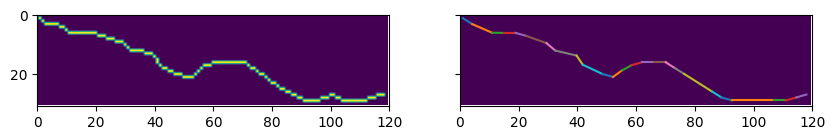

Length: 119.00, Waviness: 0.3571 



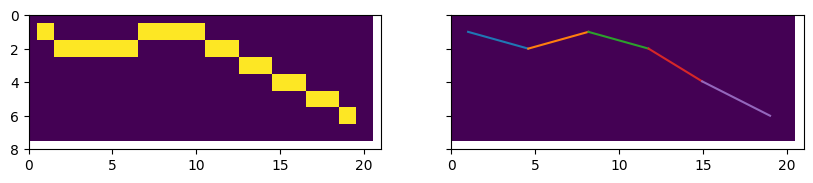

Length: 19.00, Waviness: 0.4267 



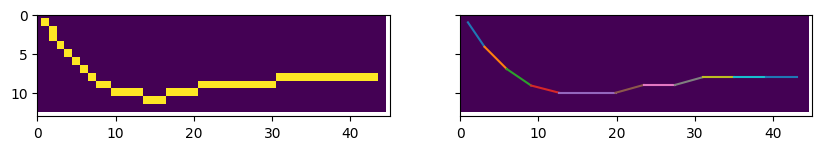

Length: 44.00, Waviness: 0.2561 



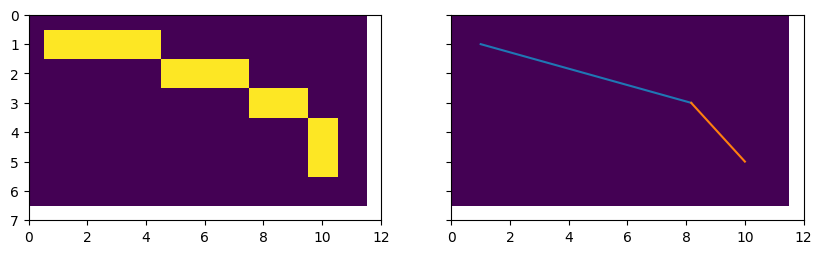

Length: 11.00, Waviness: 0.4589 



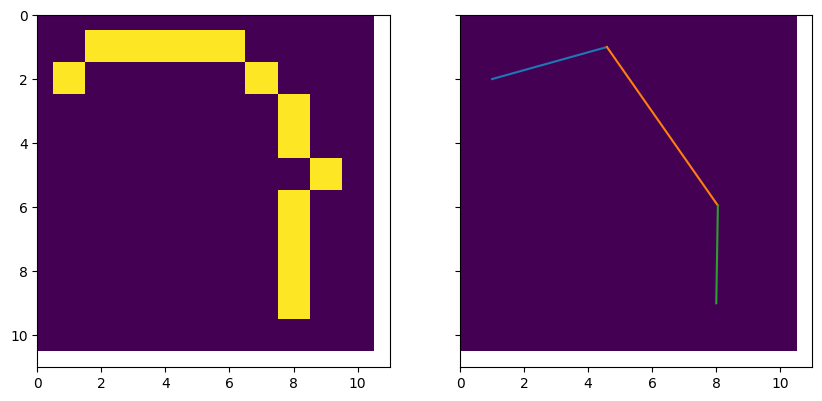

Length: 14.00, Waviness: 0.8870 



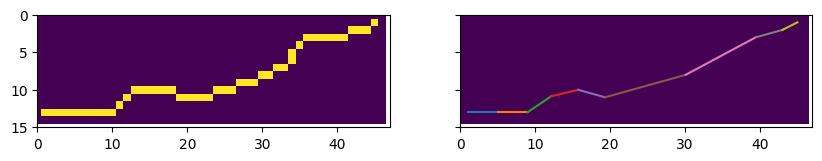

Length: 46.00, Waviness: 0.4035 



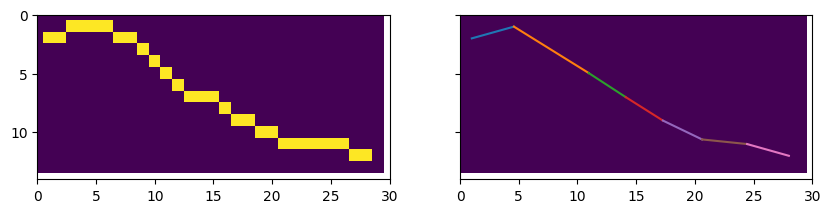

Length: 28.00, Waviness: 0.3653 



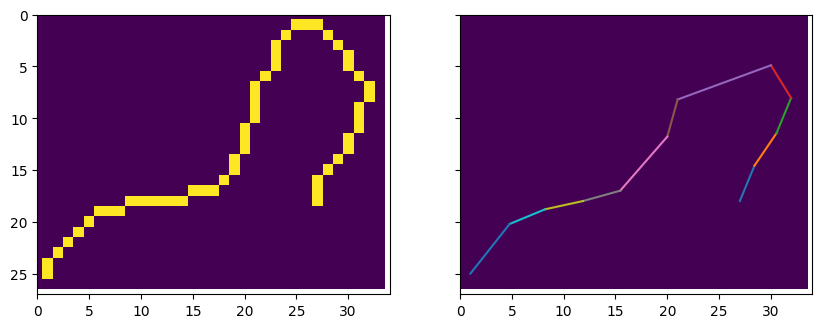

Length: 53.00, Waviness: 0.7692 



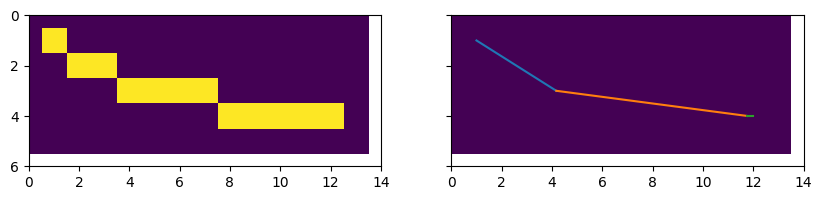

Length: 12.00, Waviness: 0.2790 



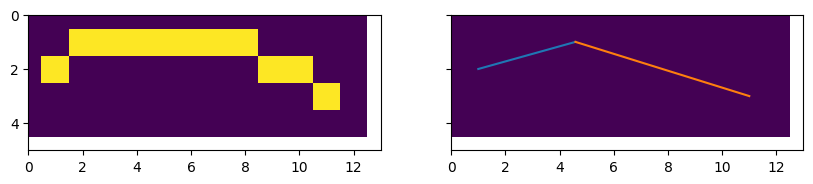

Length: 11.00, Waviness: 0.4006 



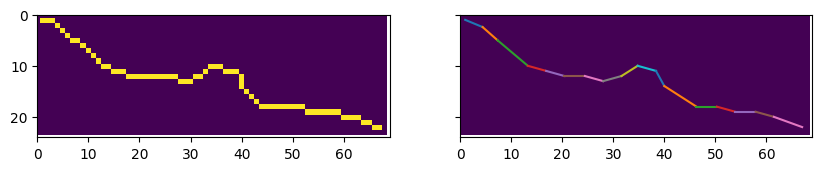

Length: 69.00, Waviness: 0.3979 



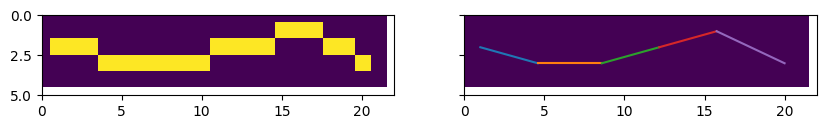

Length: 20.00, Waviness: 0.3610 



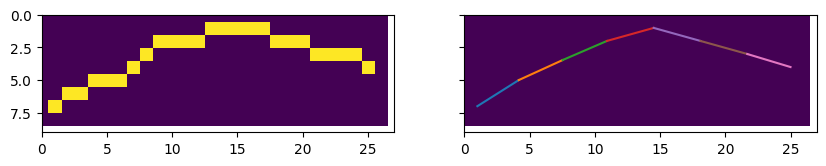

Length: 25.00, Waviness: 0.3833 



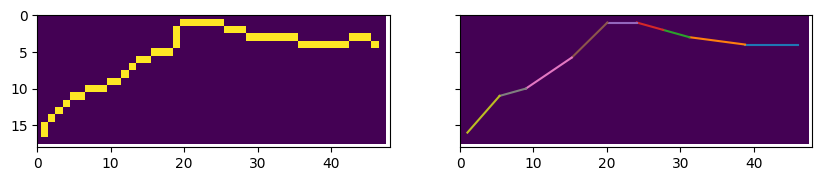

Length: 49.00, Waviness: 0.4282 



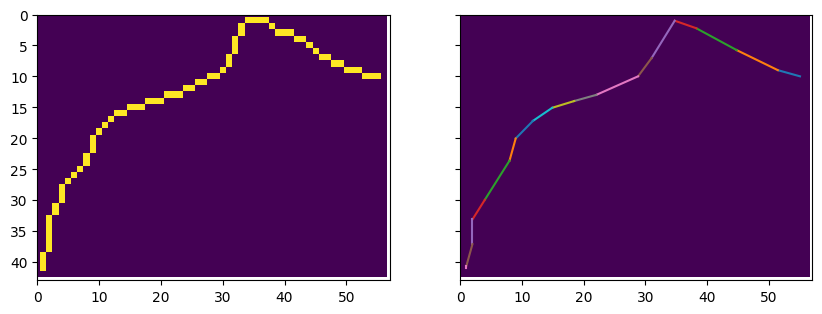

Length: 72.00, Waviness: 0.4410 



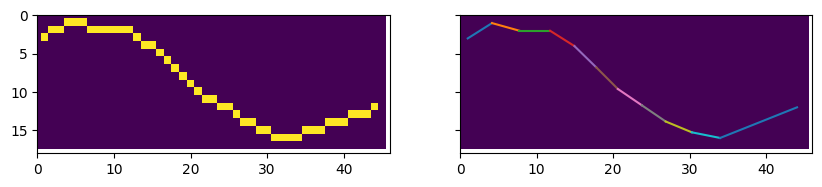

Length: 44.00, Waviness: 0.3134 



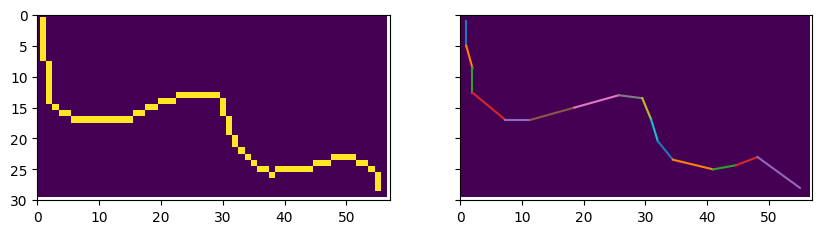

Length: 74.00, Waviness: 0.5695 



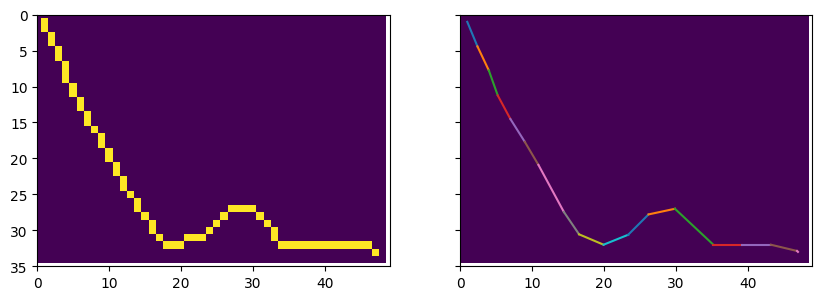

Length: 62.00, Waviness: 0.4343 



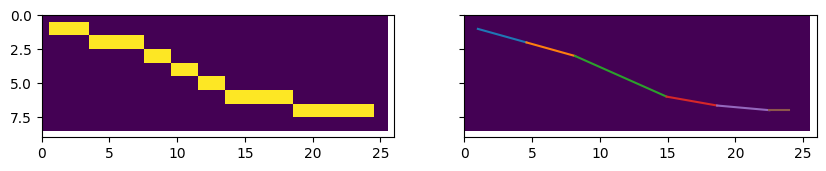

Length: 24.00, Waviness: 0.2898 



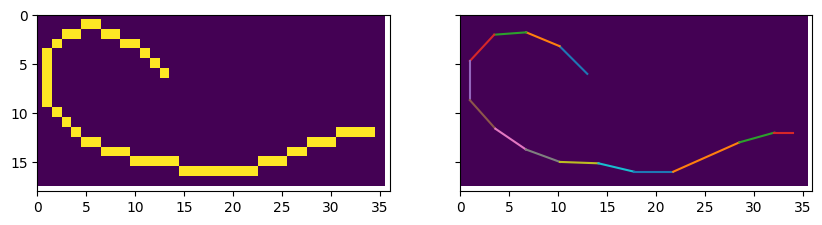

Length: 51.00, Waviness: 0.4622 



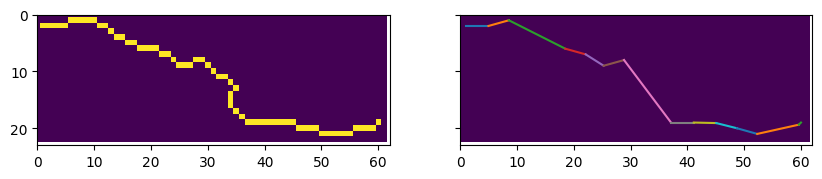

Length: 64.00, Waviness: 0.4858 



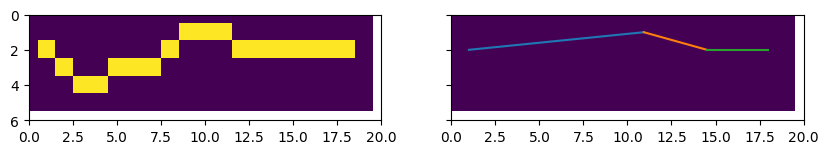

Length: 18.00, Waviness: 0.4804 



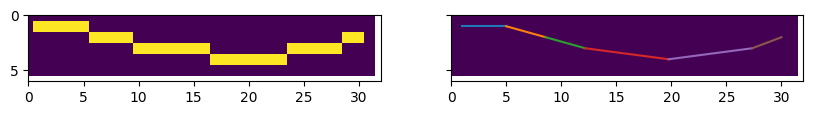

Length: 30.00, Waviness: 0.2740 



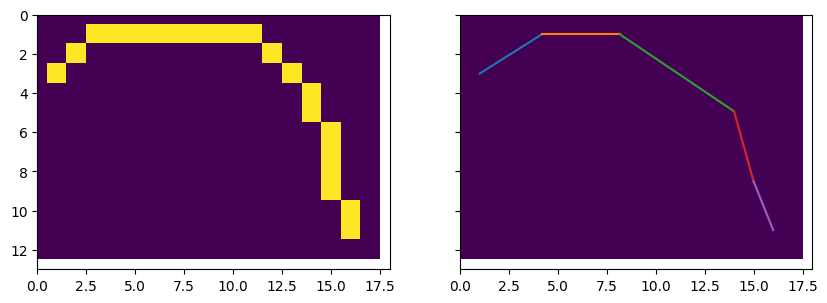

Length: 21.00, Waviness: 0.5834 



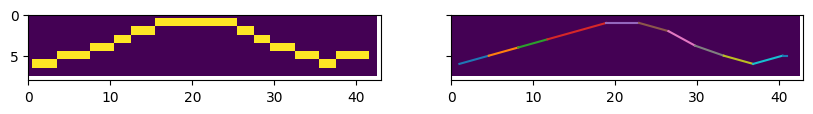

Length: 41.00, Waviness: 0.3506 



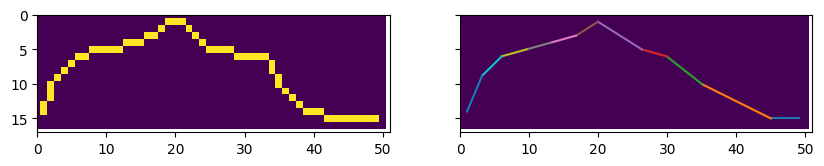

Length: 54.00, Waviness: 0.4849 



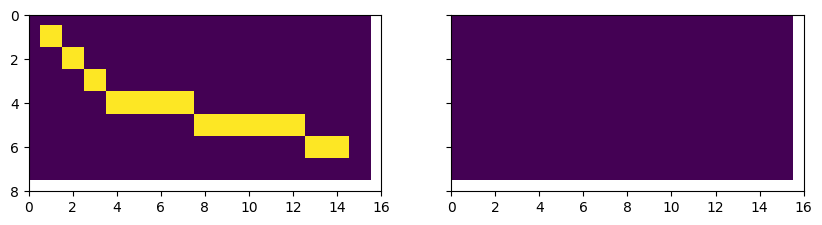

Length: 14.00, Waviness: 0.3006 



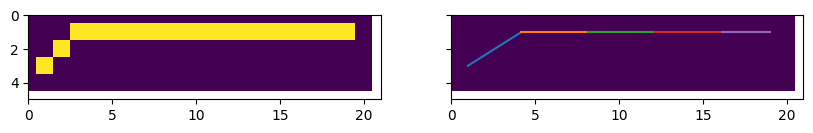

Length: 19.00, Waviness: 0.0859 



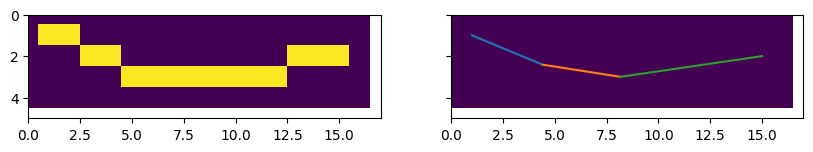

Length: 15.00, Waviness: 0.3165 



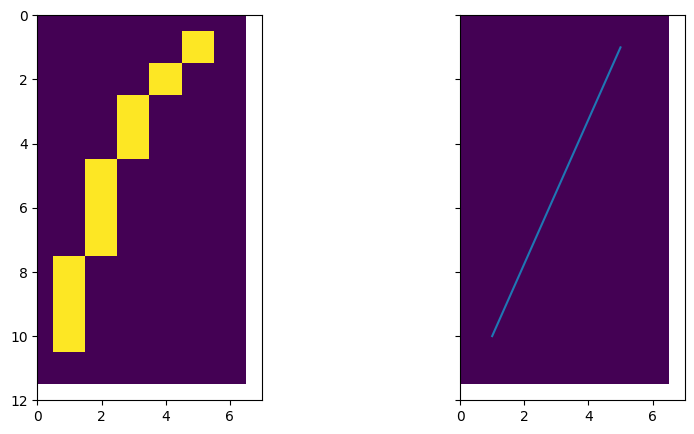

Length: 10.00, Waviness: 0.0000 



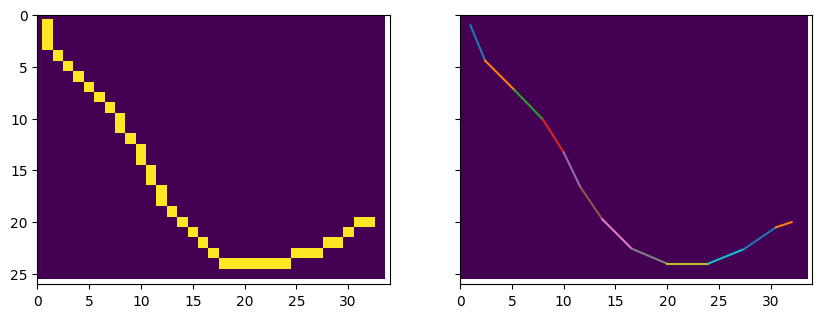

Length: 38.00, Waviness: 0.2850 



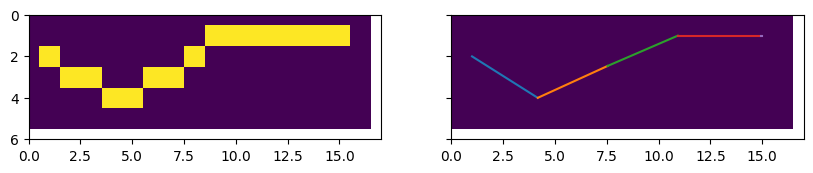

Length: 15.00, Waviness: 0.4078 



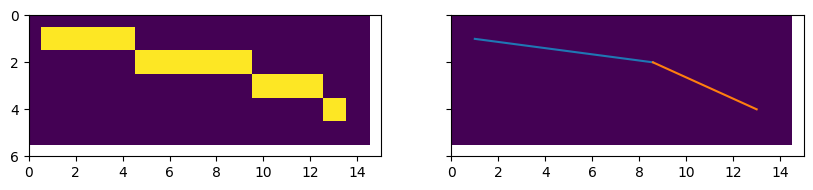

Length: 13.00, Waviness: 0.2578 



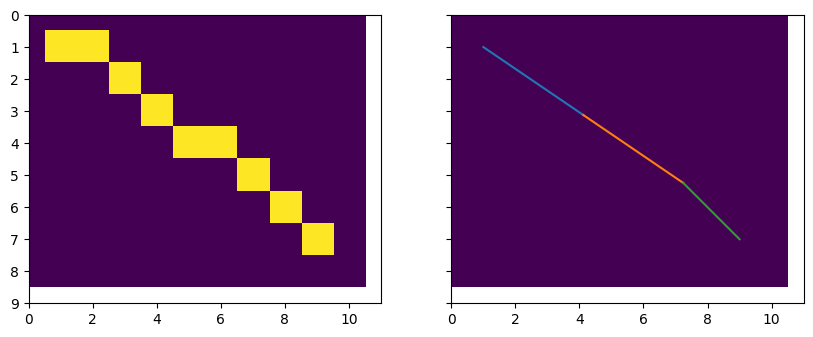

Length: 9.00, Waviness: 0.2164 



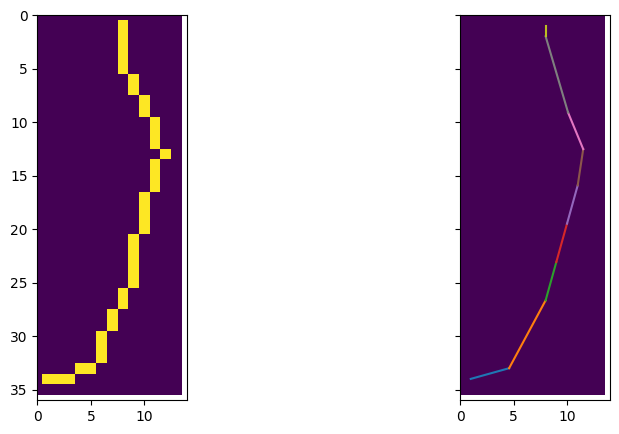

Length: 37.00, Waviness: 0.4603 



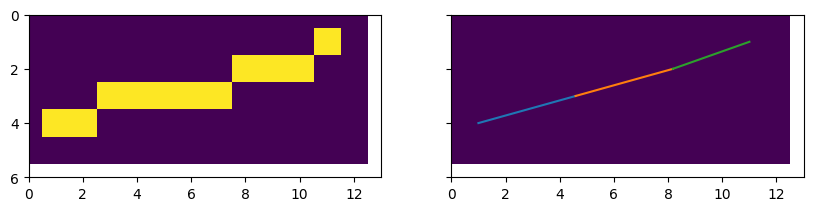

Length: 11.00, Waviness: 0.3200 



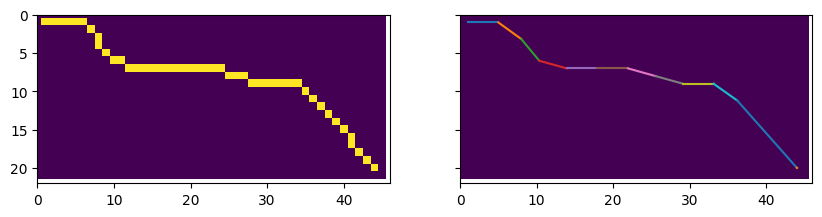

Length: 46.00, Waviness: 0.3035 



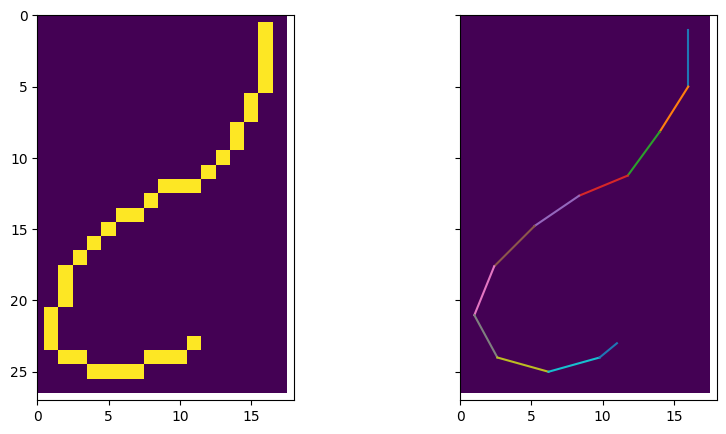

Length: 36.00, Waviness: 0.5316 



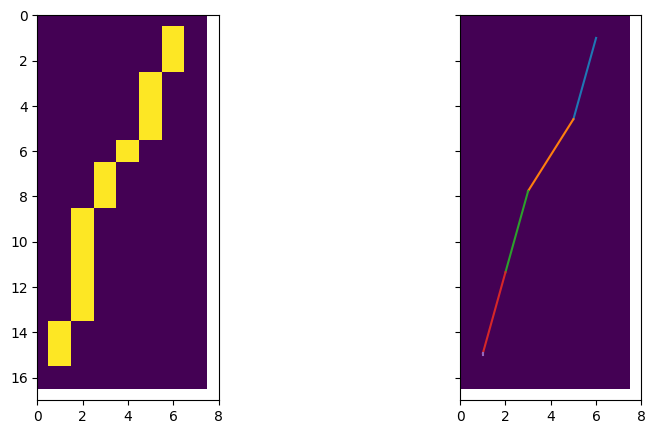

Length: 15.00, Waviness: 0.3406 



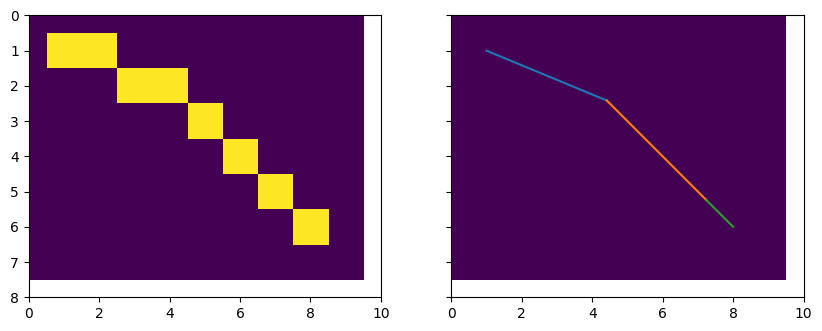

Length: 8.00, Waviness: 0.1768 



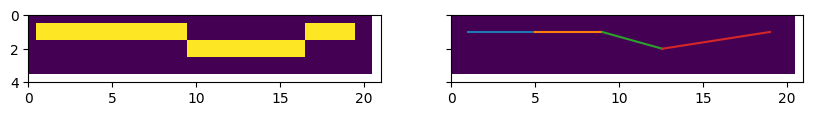

Length: 19.00, Waviness: 0.1976 



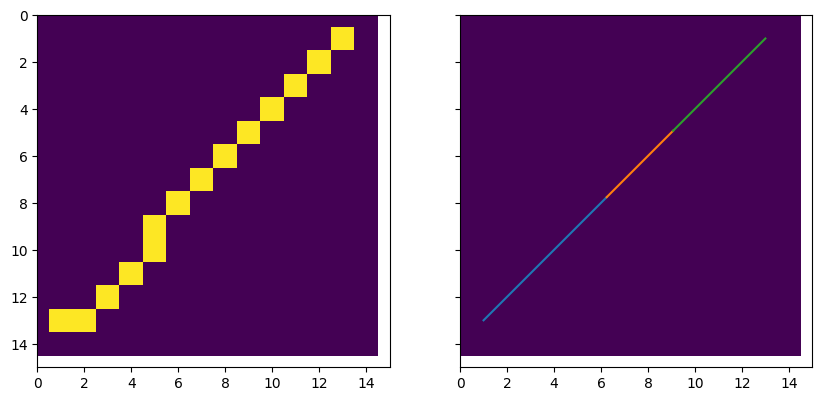

Length: 14.00, Waviness: 0.1311 



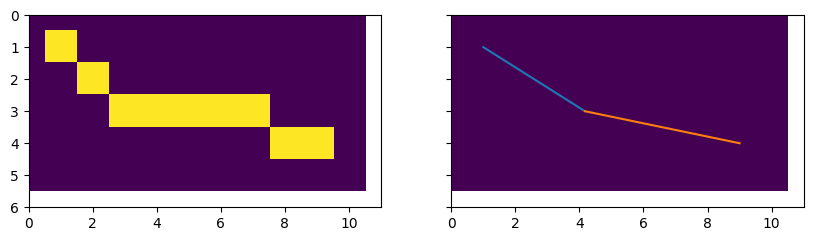

Length: 9.00, Waviness: 0.2935 



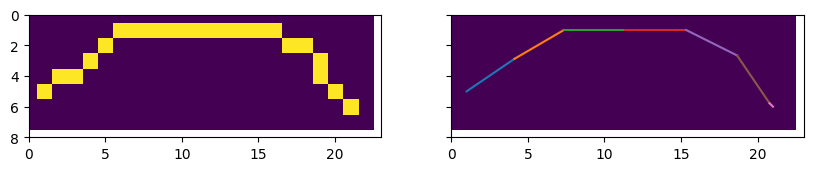

Length: 22.00, Waviness: 0.3224 



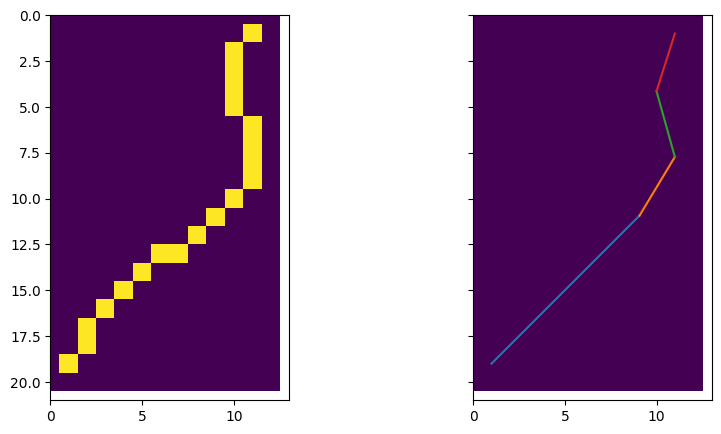

Length: 20.00, Waviness: 0.5055 



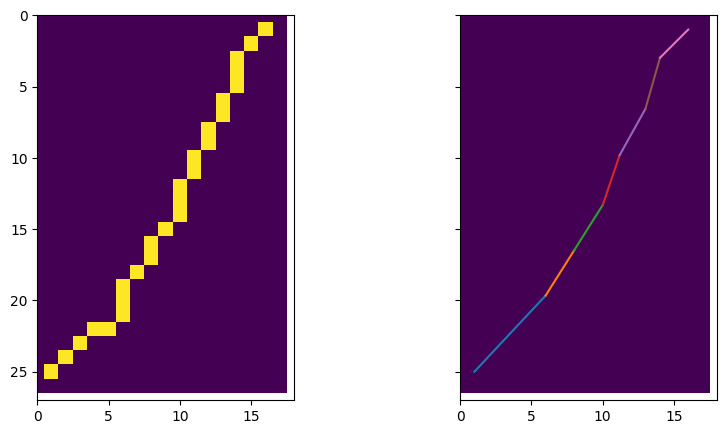

Length: 26.00, Waviness: 0.3478 



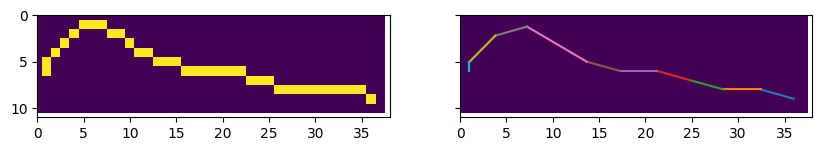

Length: 37.00, Waviness: 0.3861 



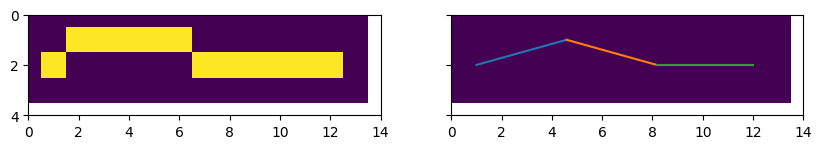

Length: 12.00, Waviness: 0.3250 



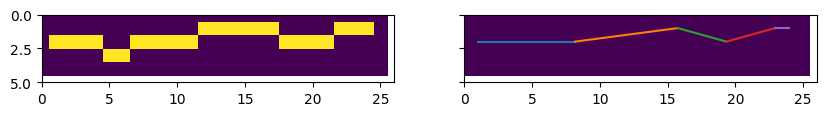

Length: 24.00, Waviness: 0.3718 



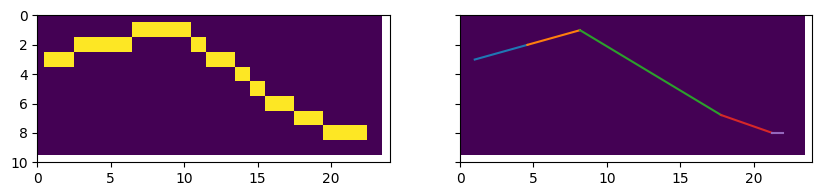

Length: 22.00, Waviness: 0.4393 



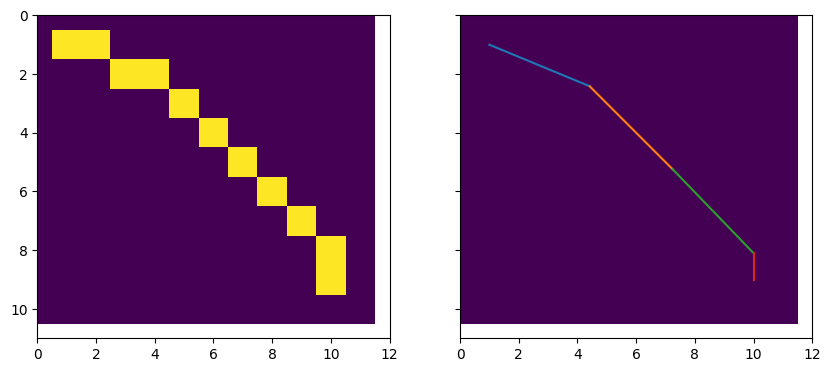

Length: 11.00, Waviness: 0.1745 



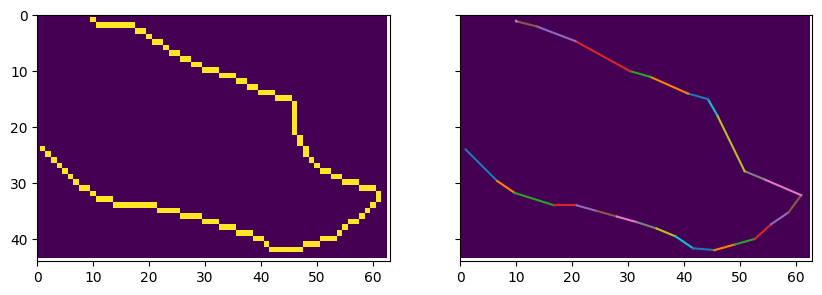

Length: 120.00, Waviness: 0.4591 



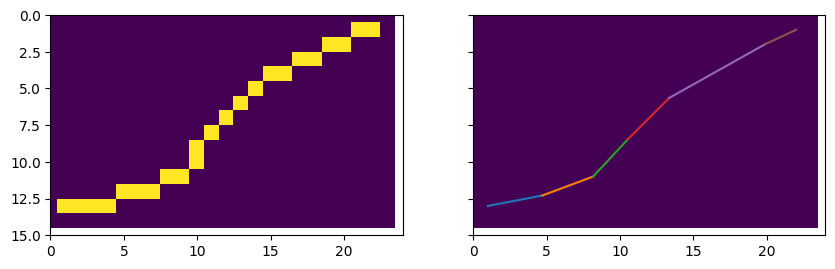

Length: 23.00, Waviness: 0.3849 



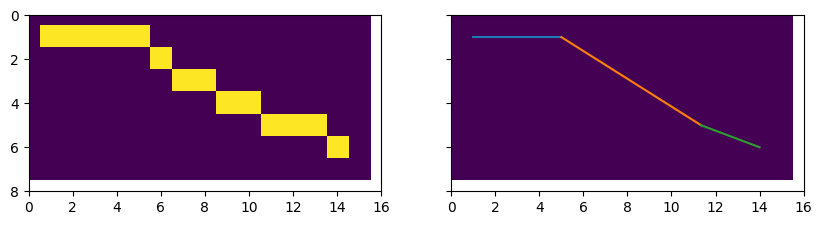

Length: 14.00, Waviness: 0.3330 



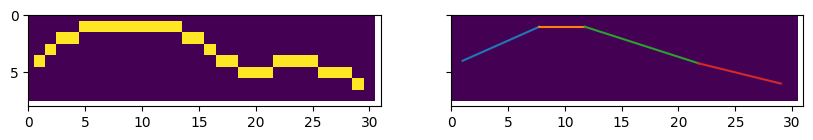

Length: 29.00, Waviness: 0.4617 



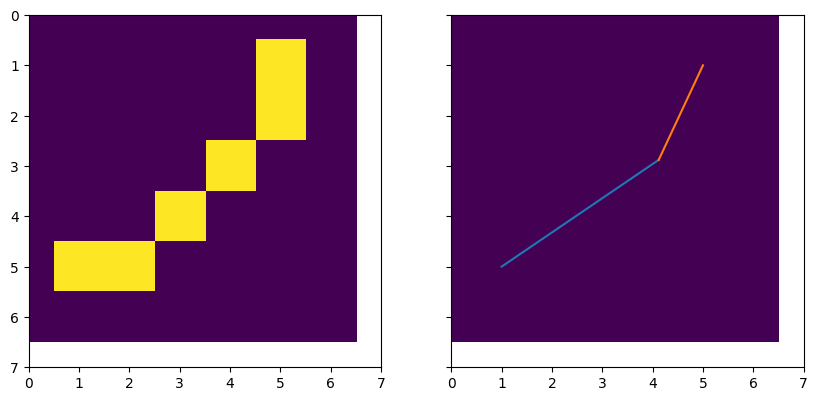

Length: 6.00, Waviness: 0.3587 



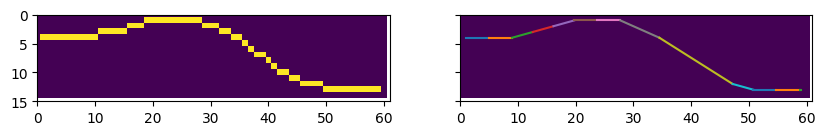

Length: 59.00, Waviness: 0.2236 



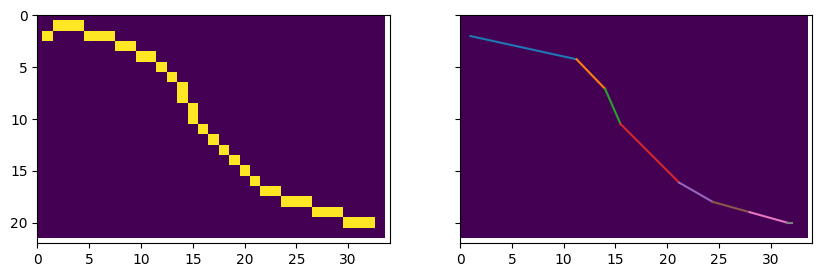

Length: 34.00, Waviness: 0.3377 



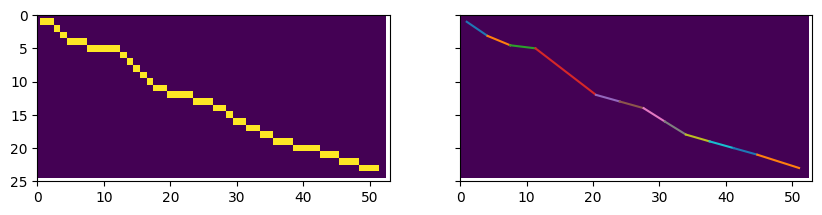

Length: 51.00, Waviness: 0.3400 



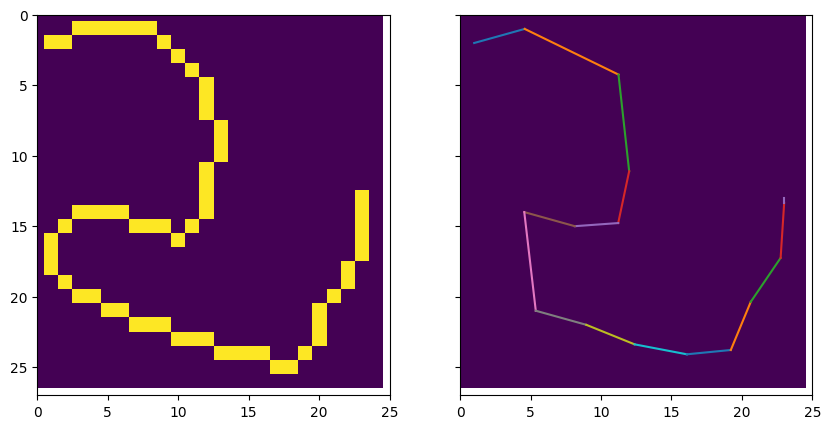

Length: 63.00, Waviness: 0.8321 



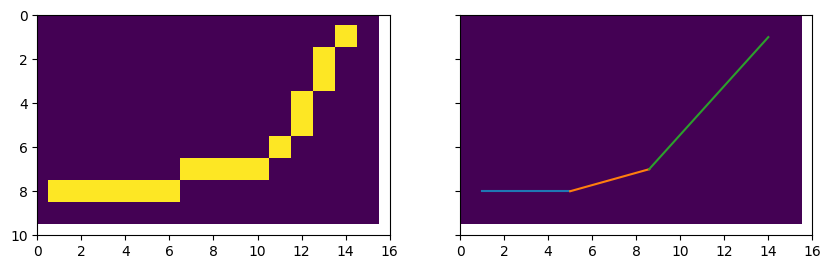

Length: 16.00, Waviness: 0.4610 



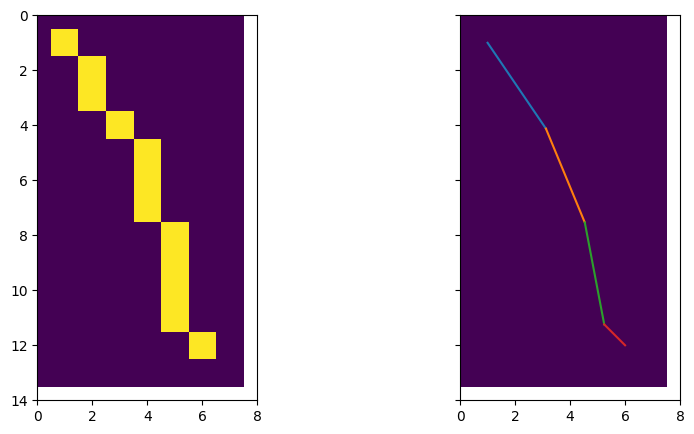

Length: 12.00, Waviness: 0.3402 



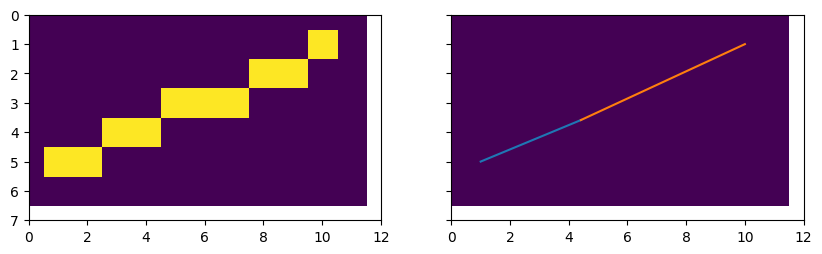

Length: 10.00, Waviness: 0.2943 



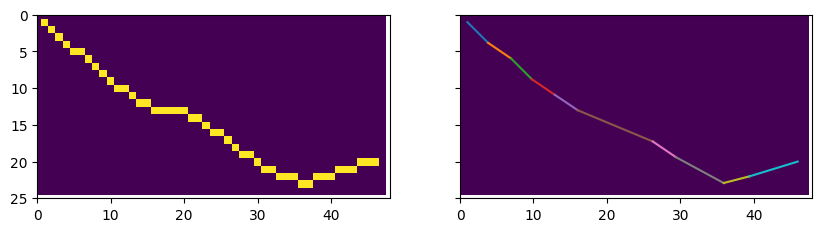

Length: 46.00, Waviness: 0.3315 



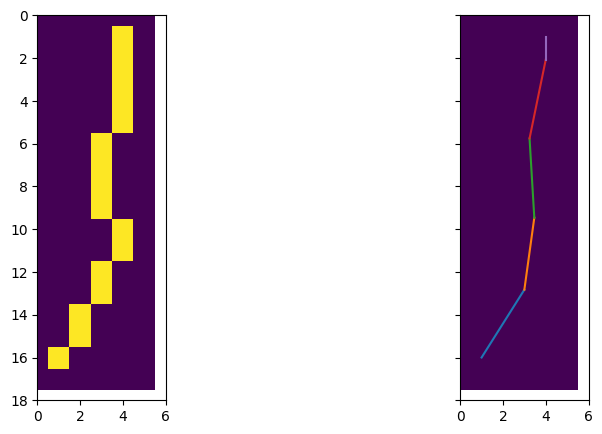

Length: 16.00, Waviness: 0.4288 



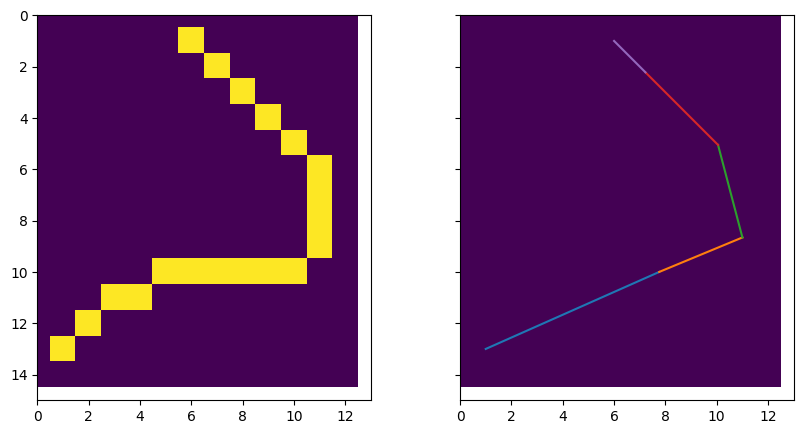

Length: 19.00, Waviness: 0.6836 



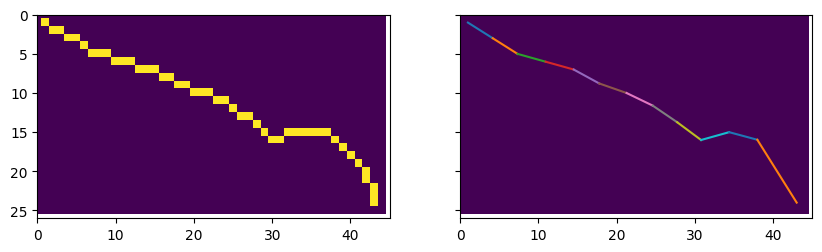

Length: 46.00, Waviness: 0.4255 



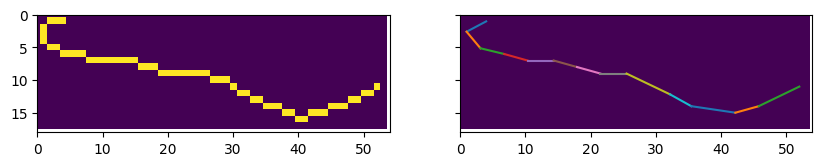

Length: 57.00, Waviness: 0.5455 



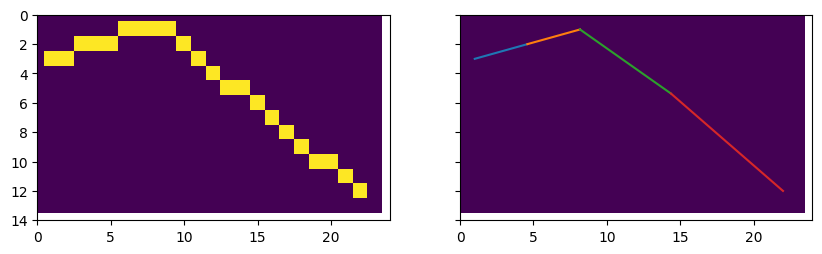

Length: 22.00, Waviness: 0.4643 



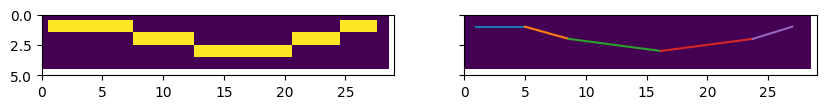

Length: 27.00, Waviness: 0.2539 



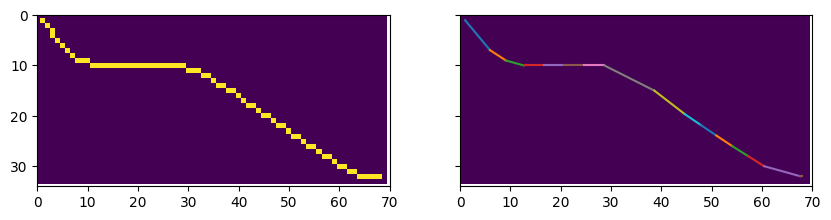

Length: 69.00, Waviness: 0.2548 



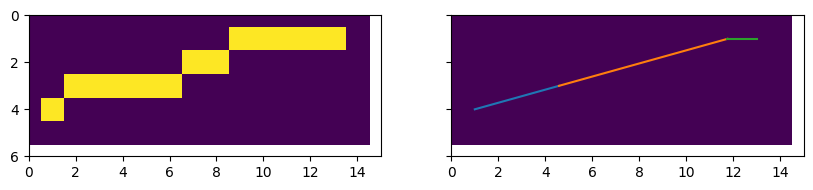

Length: 13.00, Waviness: 0.3005 



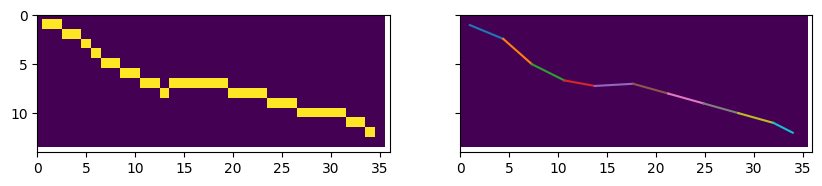

Length: 34.00, Waviness: 0.3952 



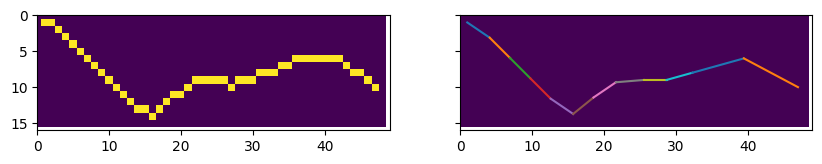

Length: 47.00, Waviness: 0.4516 



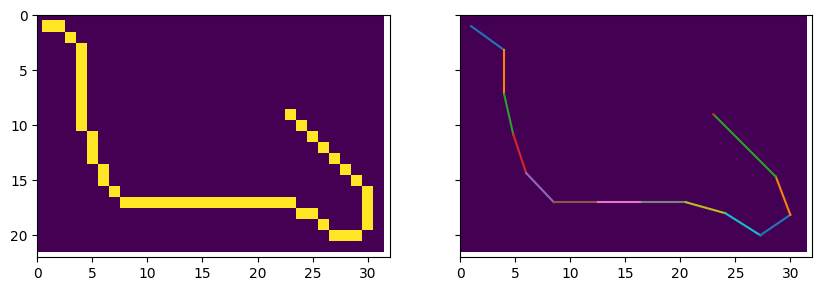

Length: 50.00, Waviness: 0.5364 



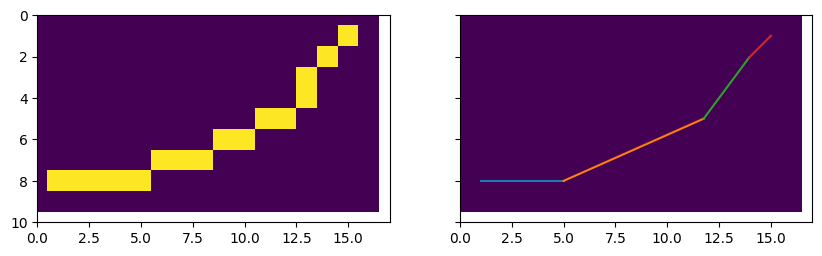

Length: 16.00, Waviness: 0.4078 



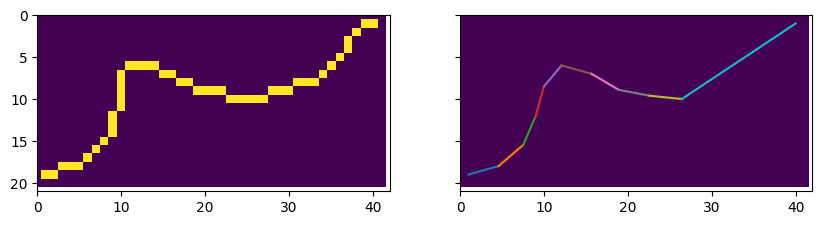

Length: 47.00, Waviness: 0.5598 



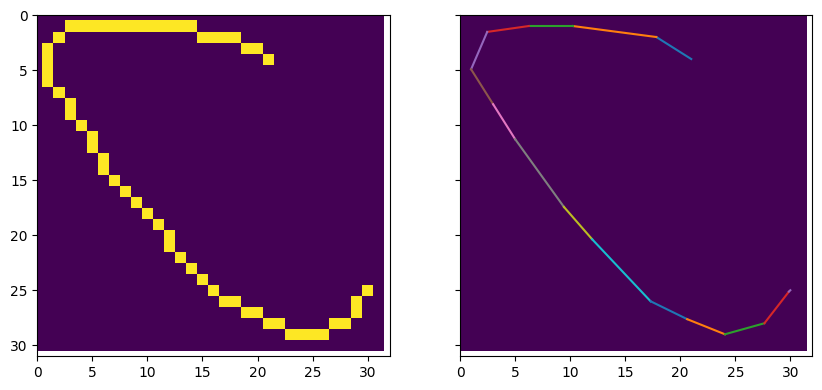

Length: 58.00, Waviness: 0.4641 



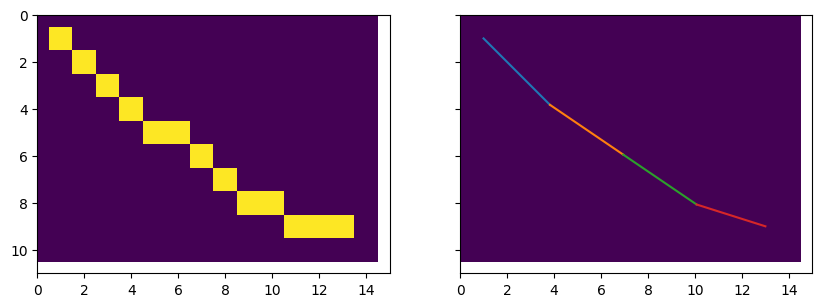

Length: 13.00, Waviness: 0.2573 



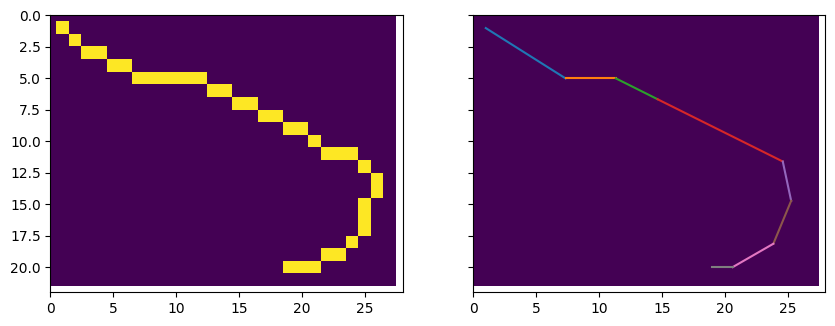

Length: 36.00, Waviness: 0.5827 



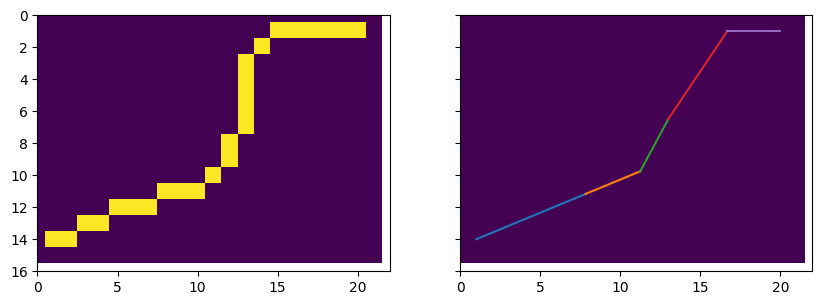

Length: 25.00, Waviness: 0.6146 



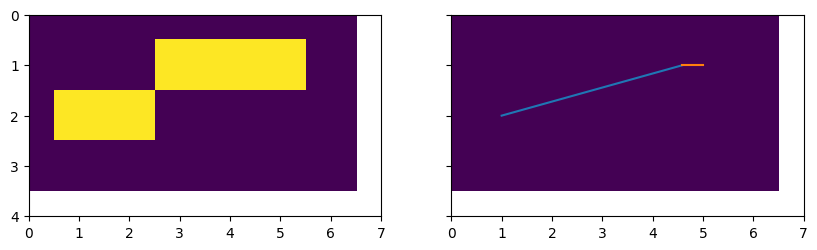

Length: 5.00, Waviness: 0.2578 



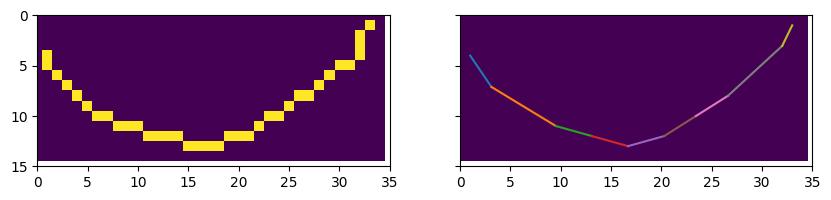

Length: 36.00, Waviness: 0.4011 



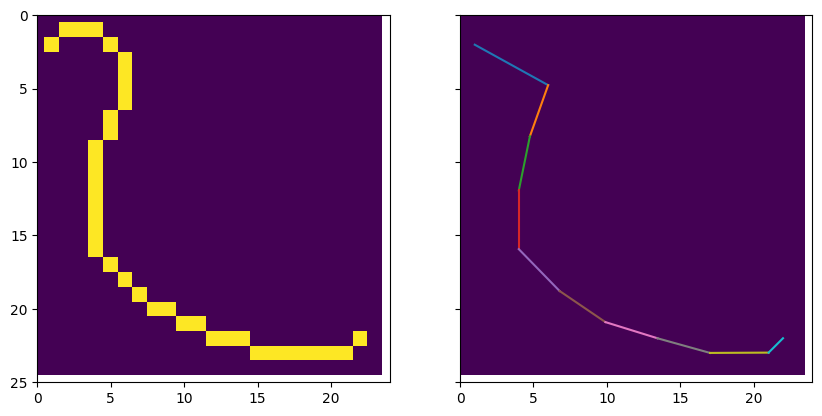

Length: 37.00, Waviness: 0.4781 



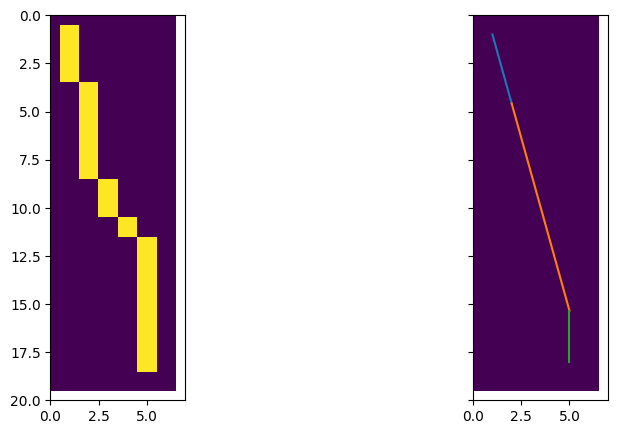

Length: 18.00, Waviness: 0.2942 



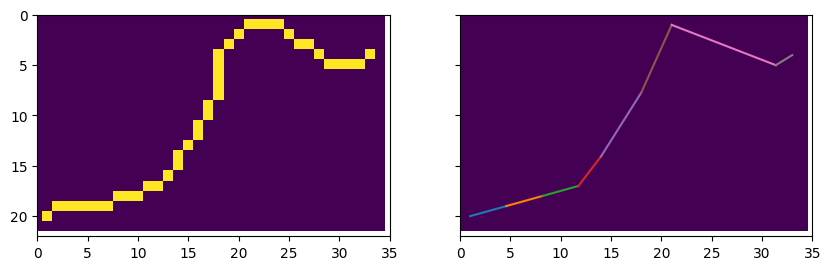

Length: 40.00, Waviness: 0.6081 



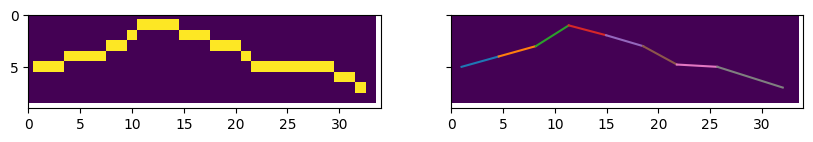

Length: 32.00, Waviness: 0.4029 



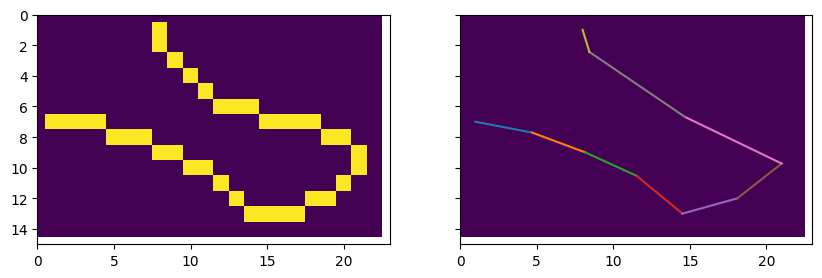

Length: 36.00, Waviness: 0.7201 



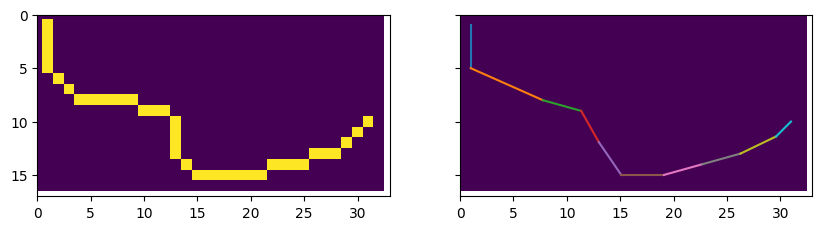

Length: 38.00, Waviness: 0.5296 



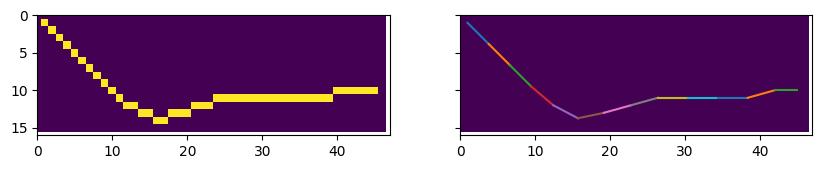

Length: 45.00, Waviness: 0.2320 



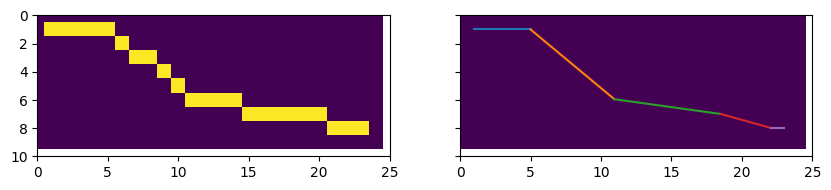

Length: 23.00, Waviness: 0.3153 



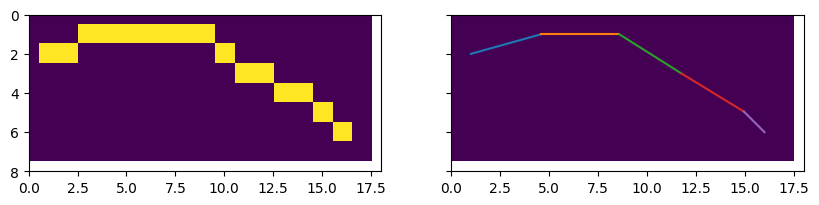

Length: 16.00, Waviness: 0.3190 



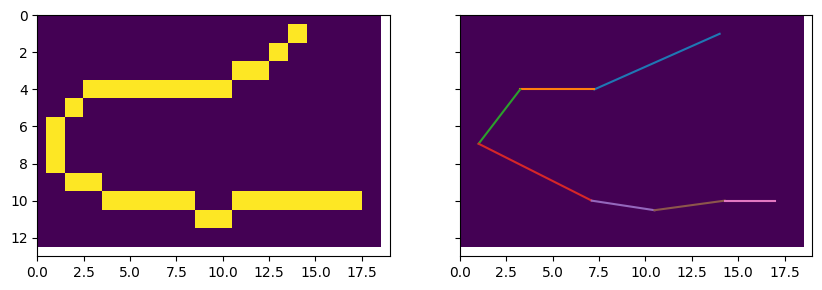

Length: 32.00, Waviness: 0.7868 



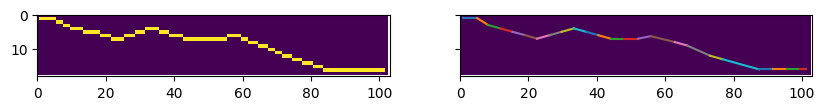

Length: 101.00, Waviness: 0.3054 



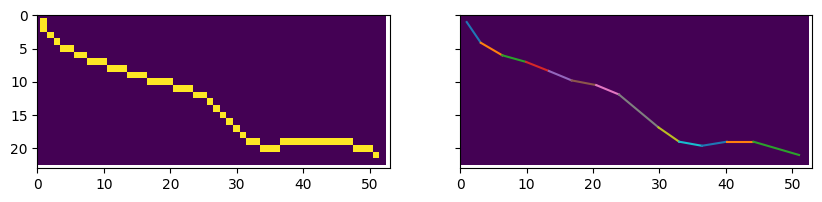

Length: 52.00, Waviness: 0.3586 



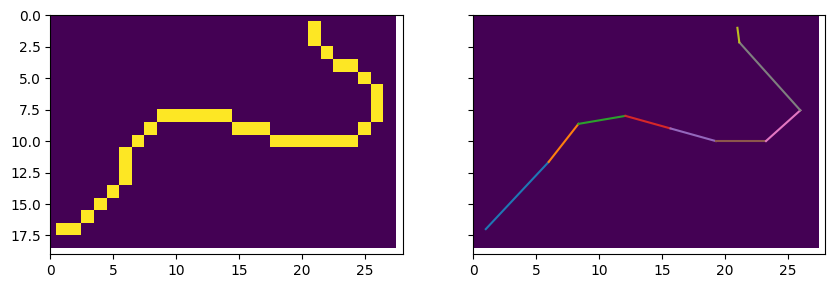

Length: 36.00, Waviness: 0.6506 



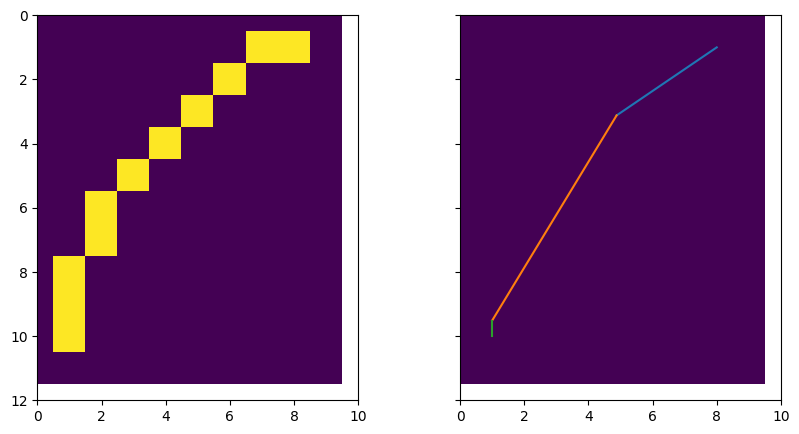

Length: 11.00, Waviness: 0.3580 



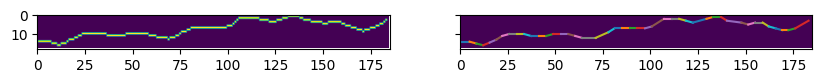

Length: 183.00, Waviness: 0.3138 



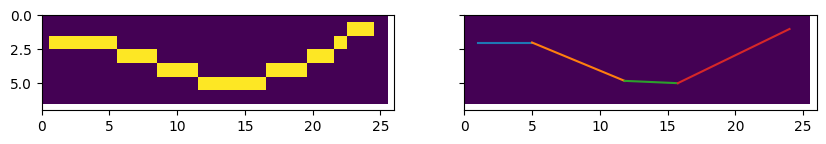

Length: 24.00, Waviness: 0.3825 



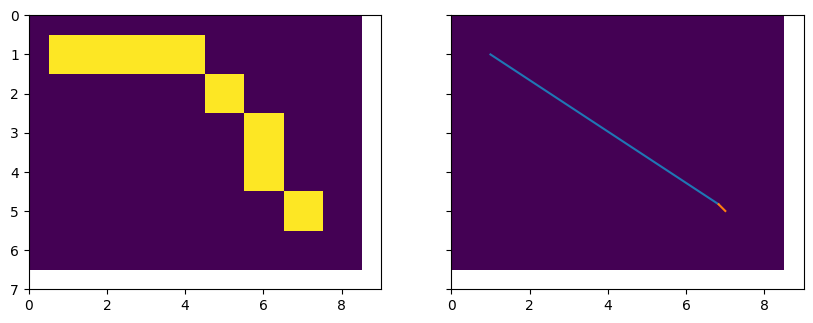

Length: 8.00, Waviness: 0.4626 



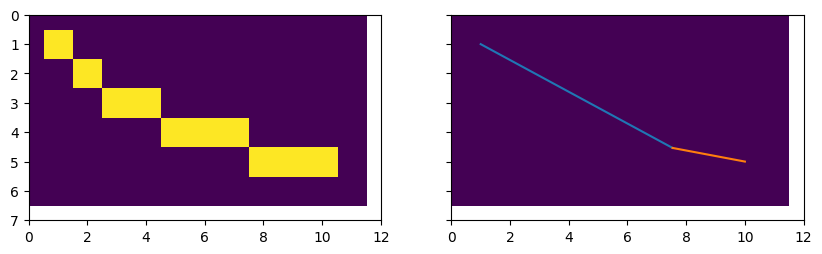

Length: 10.00, Waviness: 0.2943 



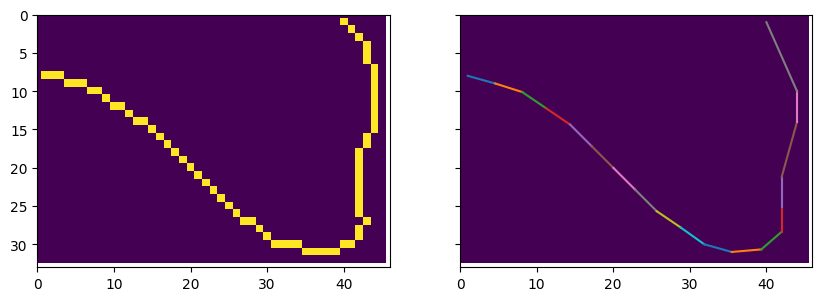

Length: 70.00, Waviness: 0.3501 



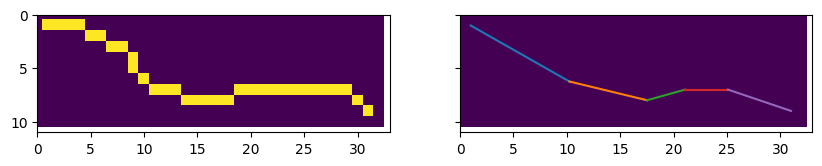

Length: 32.00, Waviness: 0.3874 



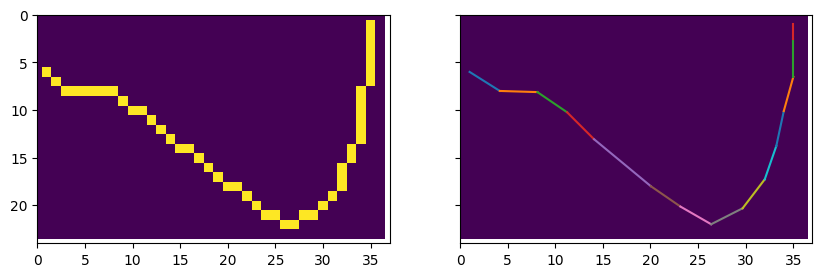

Length: 49.00, Waviness: 0.3558 



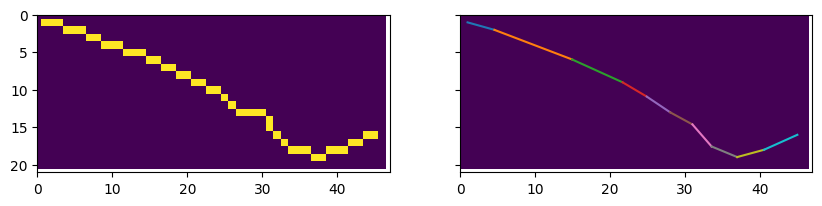

Length: 46.00, Waviness: 0.4338 



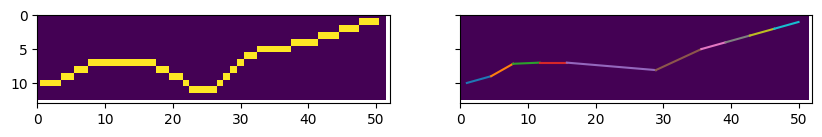

Length: 50.00, Waviness: 0.4084 



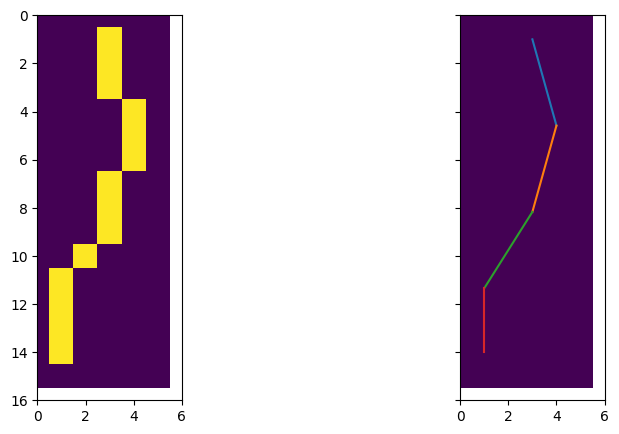

Length: 14.00, Waviness: 0.4111 



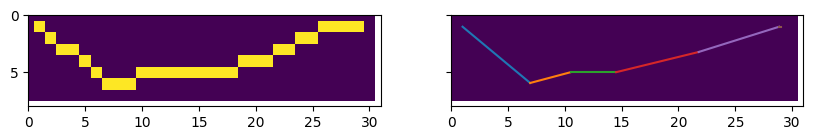

Length: 29.00, Waviness: 0.3564 



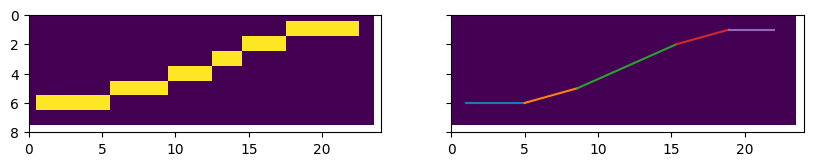

Length: 22.00, Waviness: 0.3130 



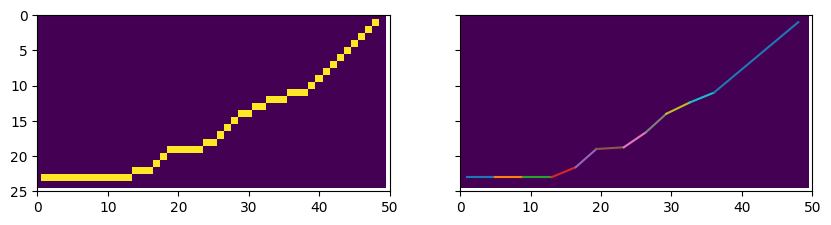

Length: 48.00, Waviness: 0.2610 



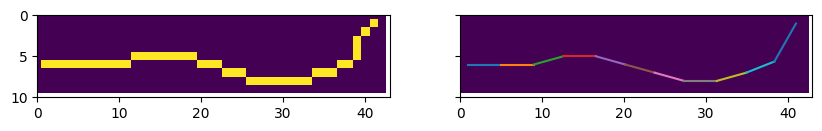

Length: 43.00, Waviness: 0.2879 



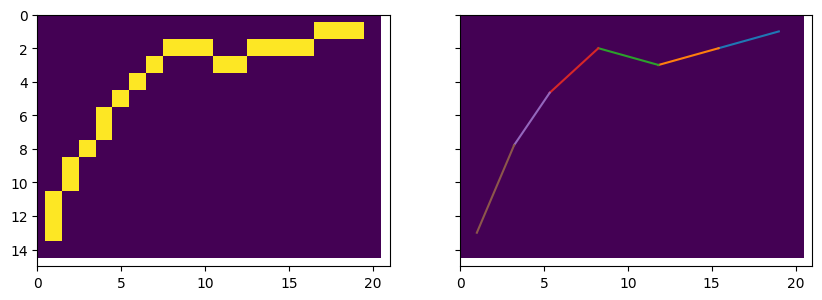

Length: 23.00, Waviness: 0.4784 



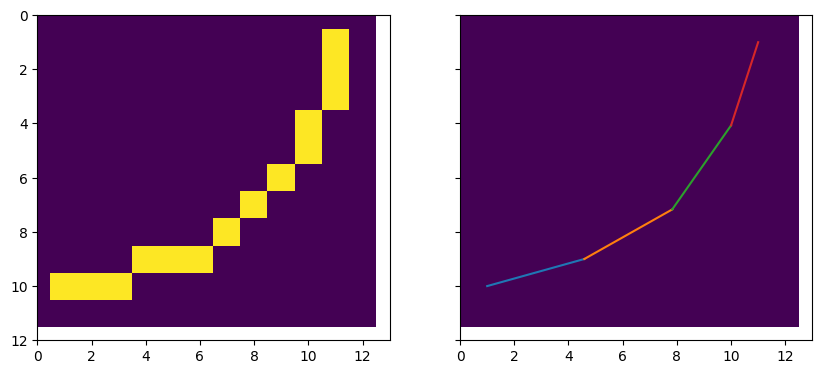

Length: 14.00, Waviness: 0.4120 



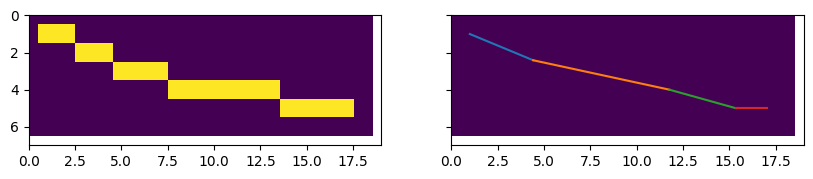

Length: 17.00, Waviness: 0.2970 



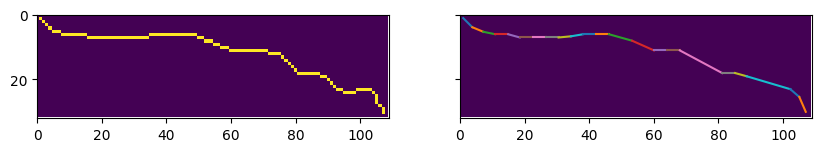

Length: 110.00, Waviness: 0.2696 



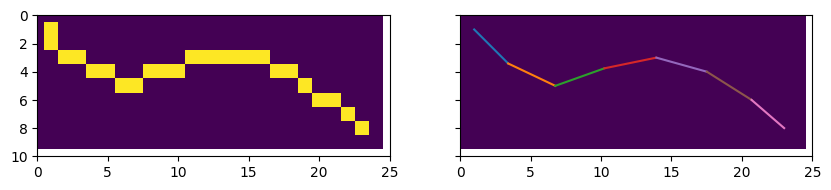

Length: 24.00, Waviness: 0.4842 



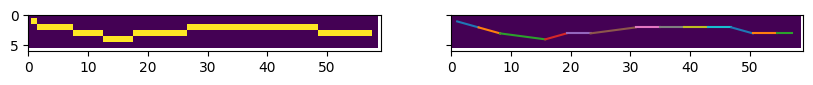

Length: 57.00, Waviness: 0.1631 



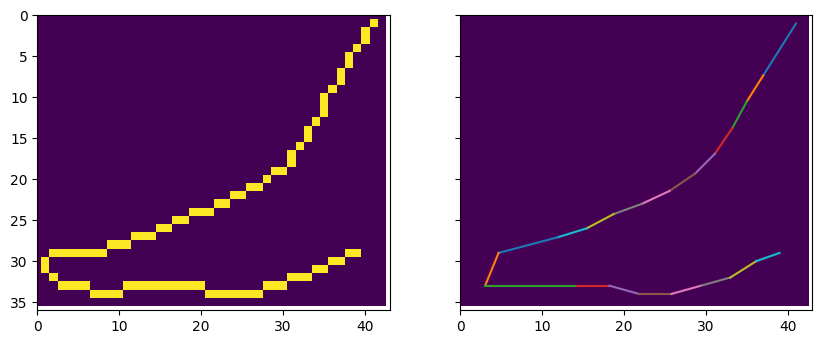

Length: 87.00, Waviness: 0.5590 



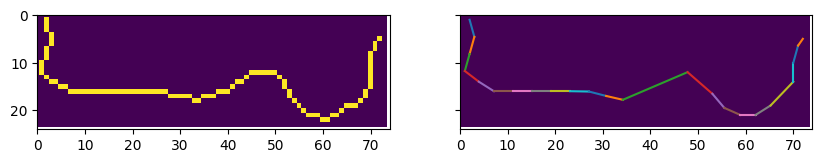

Length: 94.00, Waviness: 0.4807 



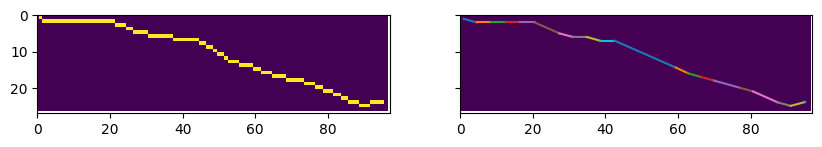

Length: 95.00, Waviness: 0.2886 



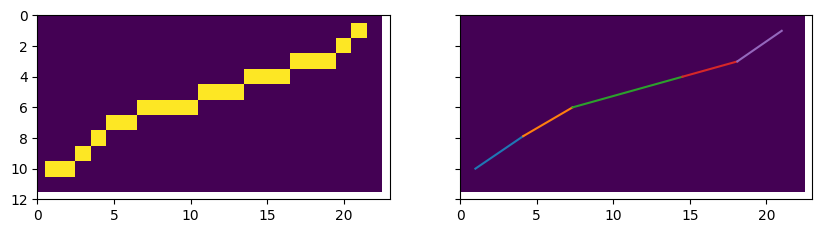

Length: 21.00, Waviness: 0.3409 



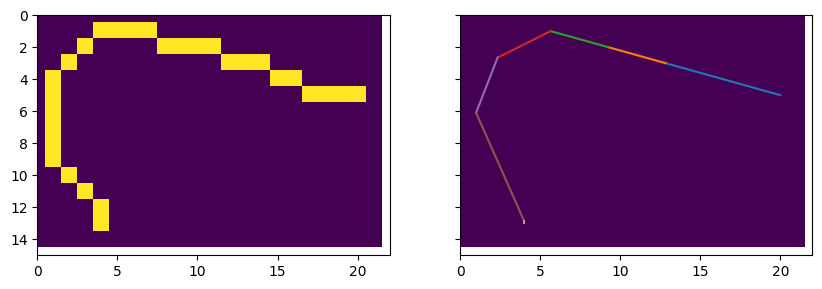

Length: 29.00, Waviness: 0.5866 



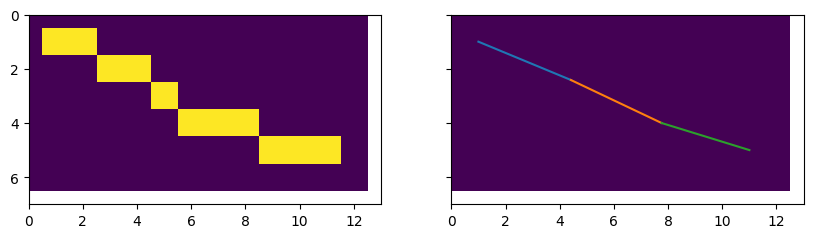

Length: 11.00, Waviness: 0.3404 



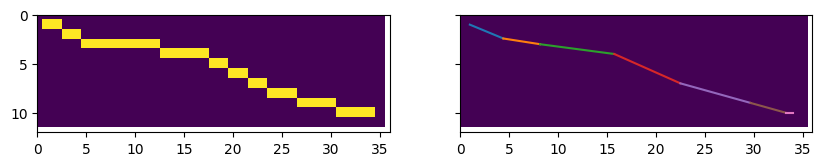

Length: 34.00, Waviness: 0.3149 



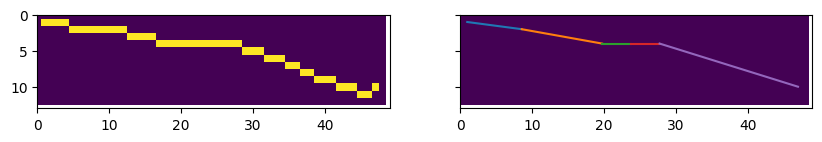

Length: 47.00, Waviness: 0.2464 



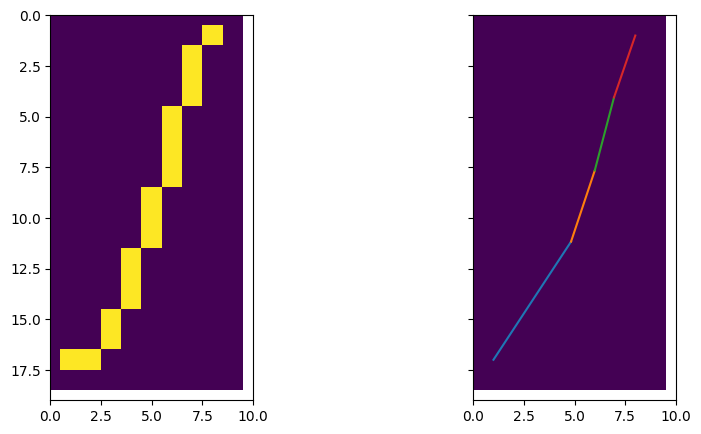

Length: 18.00, Waviness: 0.4016 



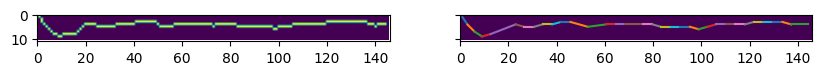

Length: 145.00, Waviness: 0.2471 



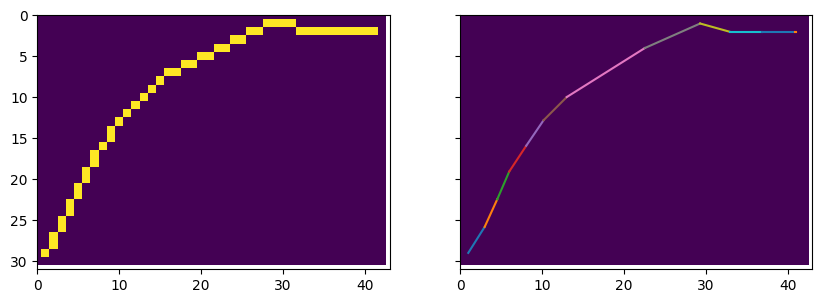

Length: 48.00, Waviness: 0.2820 



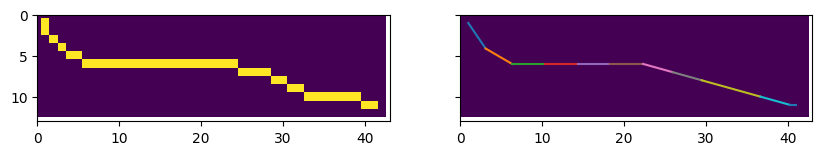

Length: 42.00, Waviness: 0.2390 



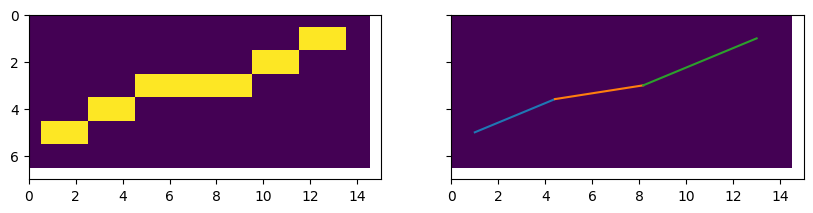

Length: 13.00, Waviness: 0.3233 



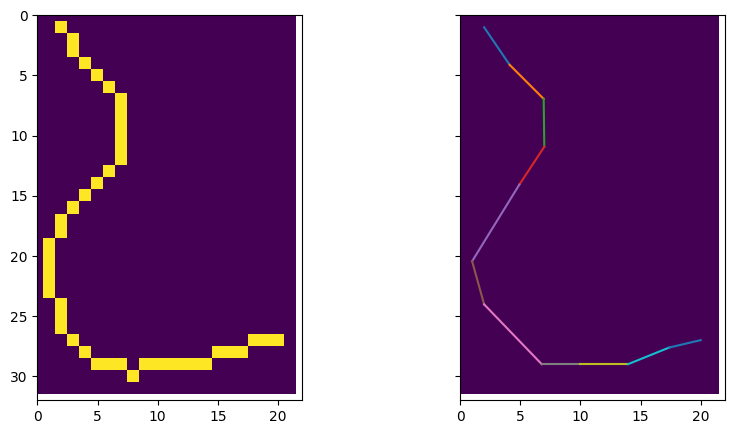

Length: 44.00, Waviness: 0.5421 



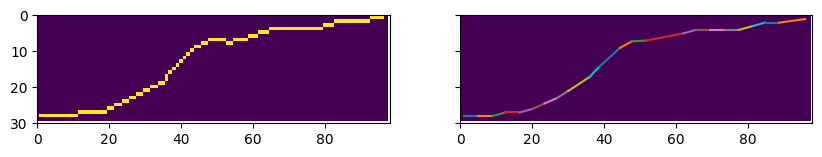

Length: 97.00, Waviness: 0.2732 



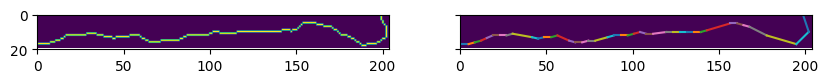

Length: 214.00, Waviness: 0.3308 



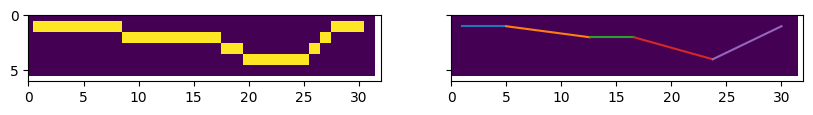

Length: 30.00, Waviness: 0.2865 



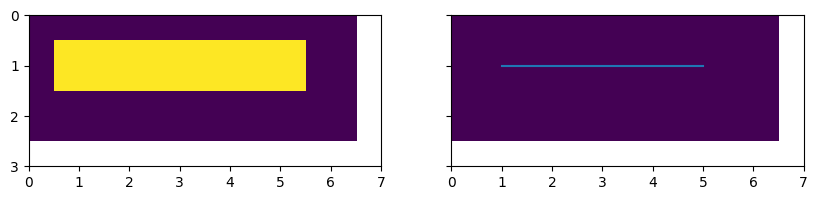

Length: 5.00, Waviness: 0.0000 



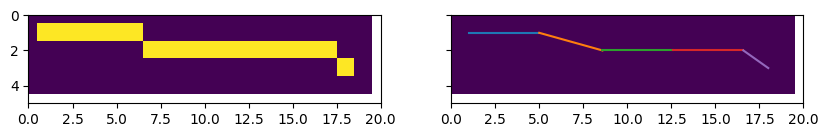

Length: 18.00, Waviness: 0.1644 



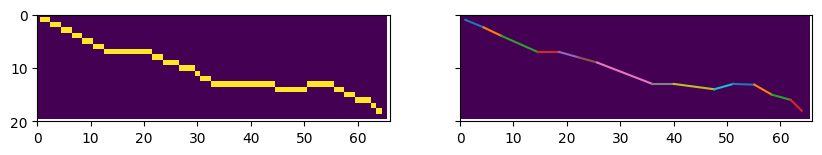

Length: 64.00, Waviness: 0.3221 



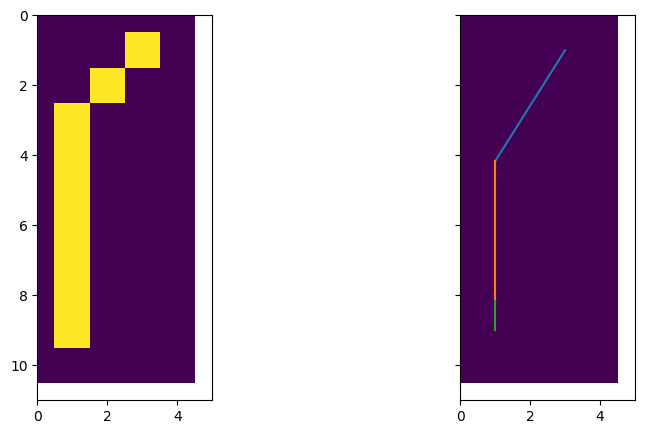

Length: 9.00, Waviness: 0.2207 



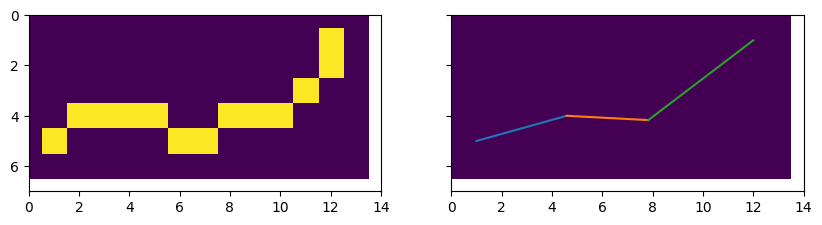

Length: 13.00, Waviness: 0.6627 



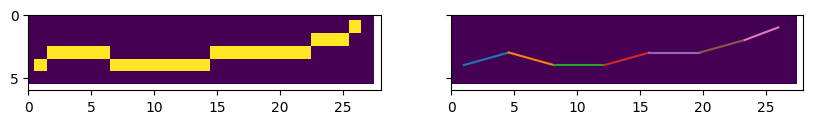

Length: 26.00, Waviness: 0.2735 



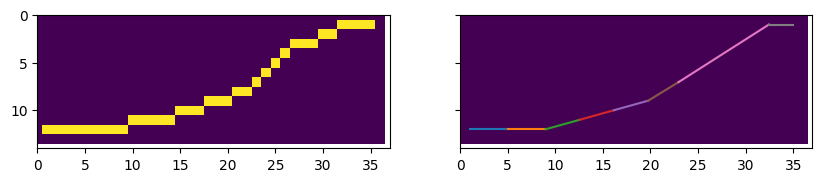

Length: 35.00, Waviness: 0.2853 



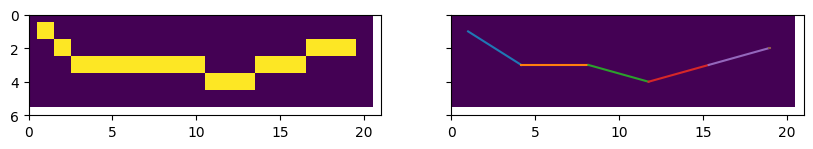

Length: 19.00, Waviness: 0.3473 



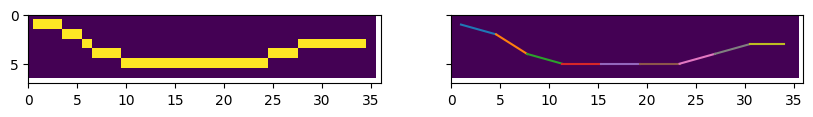

Length: 34.00, Waviness: 0.2178 



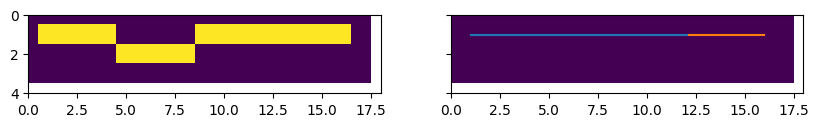

Length: 16.00, Waviness: 0.2063 



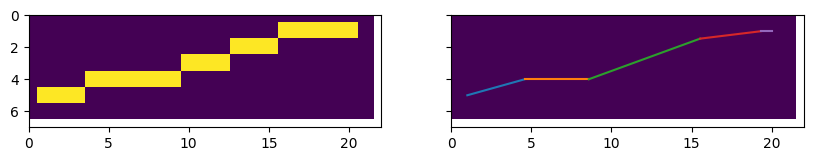

Length: 20.00, Waviness: 0.2779 



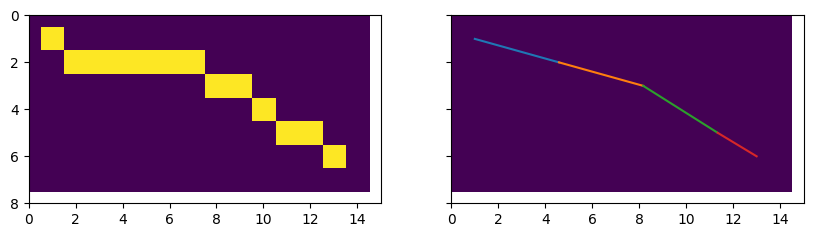

Length: 13.00, Waviness: 0.3346 



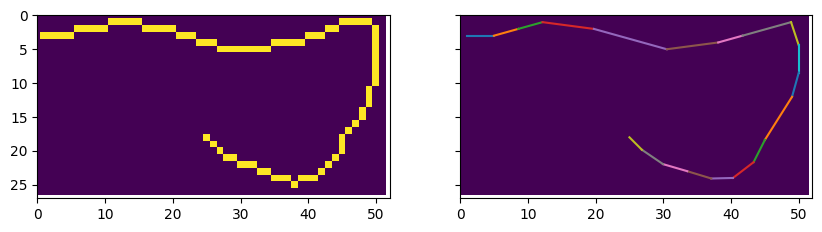

Length: 88.00, Waviness: 0.4773 



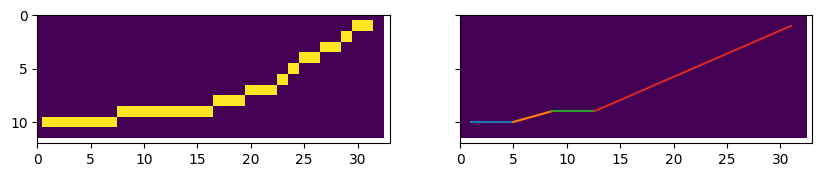

Length: 31.00, Waviness: 0.2507 



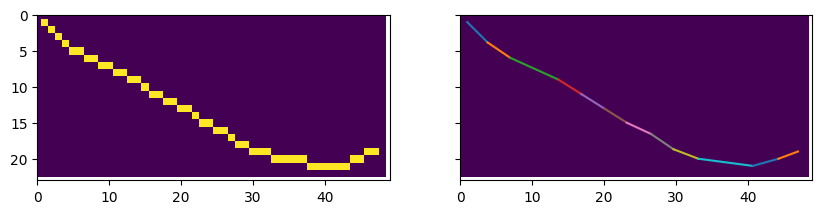

Length: 47.00, Waviness: 0.3273 



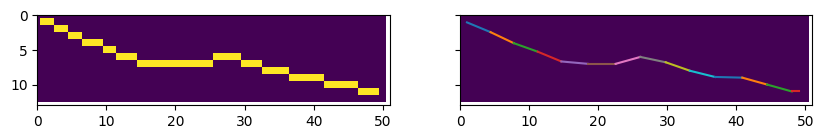

Length: 49.00, Waviness: 0.3059 



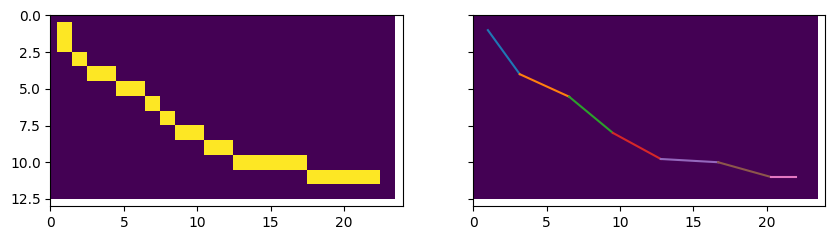

Length: 23.00, Waviness: 0.3178 



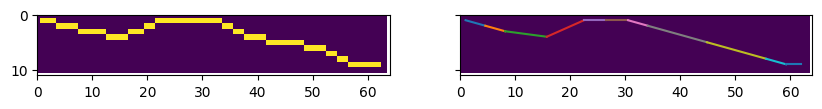

Length: 62.00, Waviness: 0.3012 



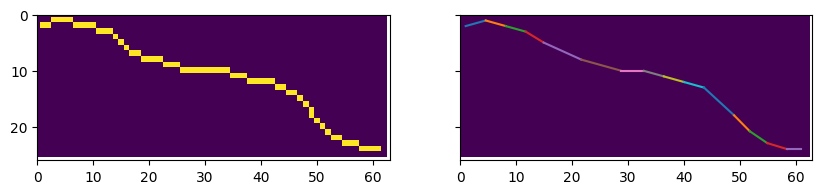

Length: 62.00, Waviness: 0.3414 



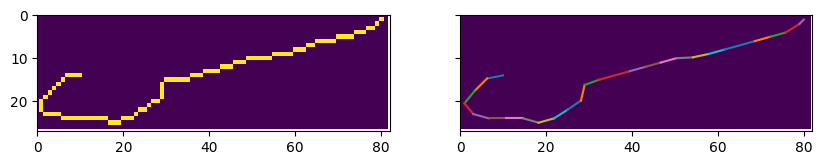

Length: 94.00, Waviness: 0.4416 



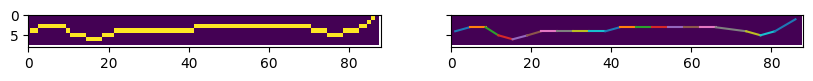

Length: 86.00, Waviness: 0.2023 



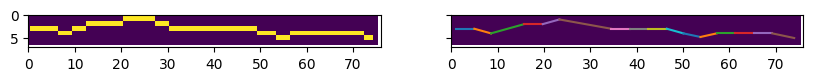

Length: 74.00, Waviness: 0.2301 



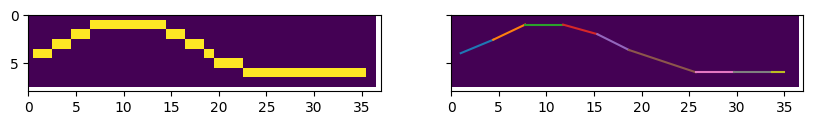

Length: 35.00, Waviness: 0.2646 



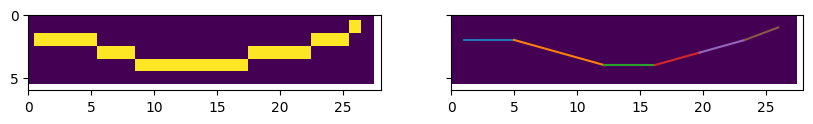

Length: 26.00, Waviness: 0.2861 



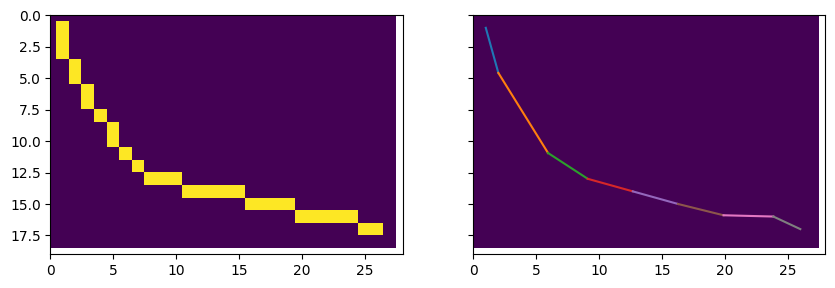

Length: 31.00, Waviness: 0.3428 



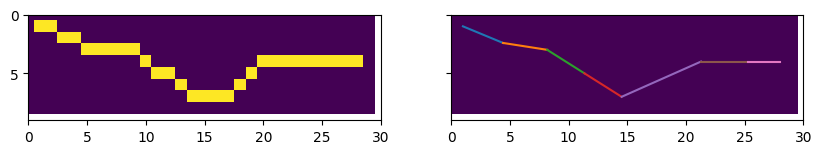

Length: 28.00, Waviness: 0.4180 



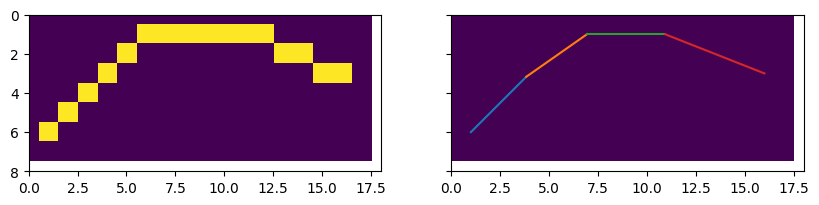

Length: 16.00, Waviness: 0.3528 



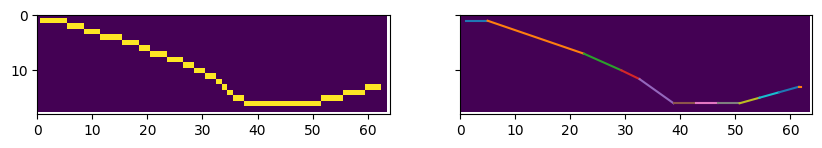

Length: 62.00, Waviness: 0.2765 



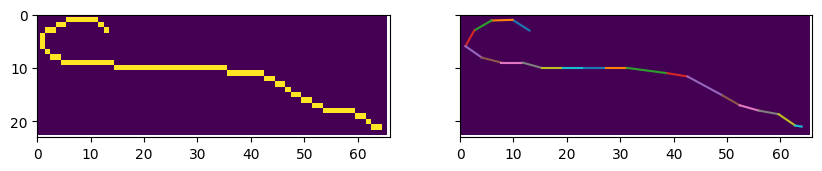

Length: 78.00, Waviness: 0.4038 



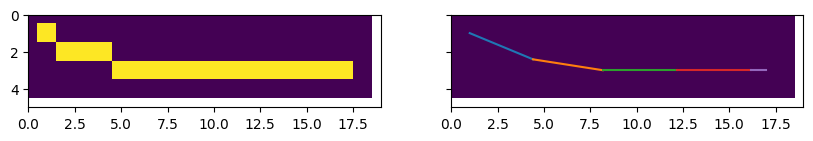

Length: 17.00, Waviness: 0.1176 



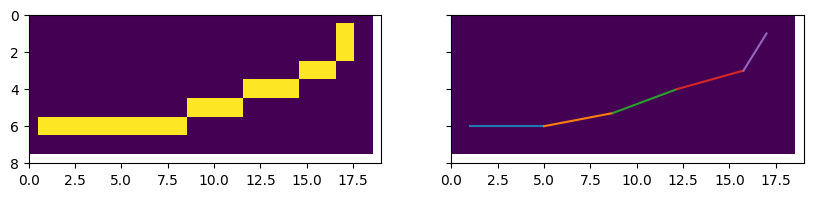

Length: 18.00, Waviness: 0.3762 



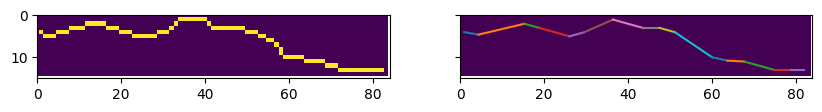

Length: 83.00, Waviness: 0.3854 



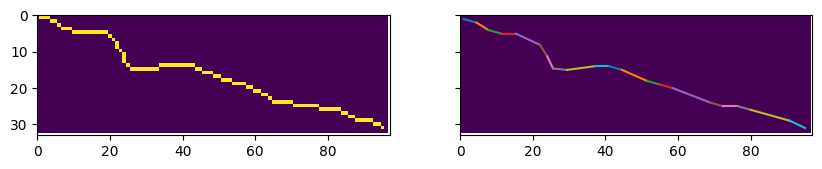

Length: 98.00, Waviness: 0.3694 



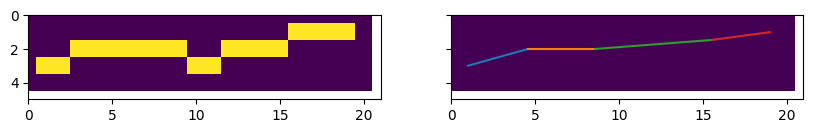

Length: 19.00, Waviness: 0.3647 



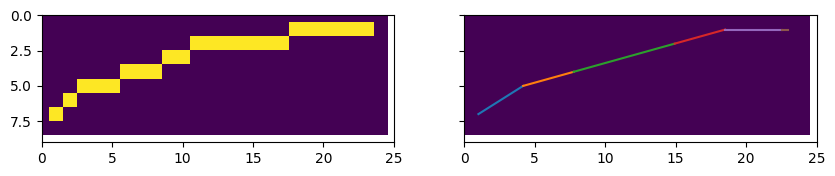

Length: 23.00, Waviness: 0.2709 



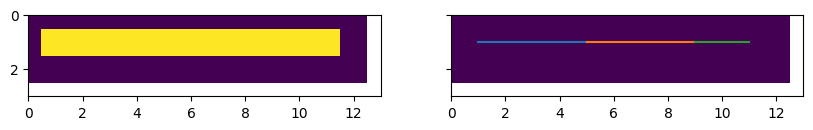

Length: 11.00, Waviness: 0.0000 



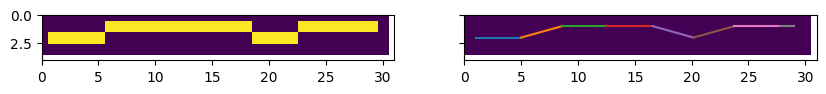

Length: 29.00, Waviness: 0.2069 



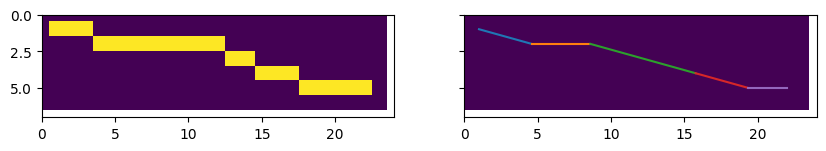

Length: 22.00, Waviness: 0.2714 



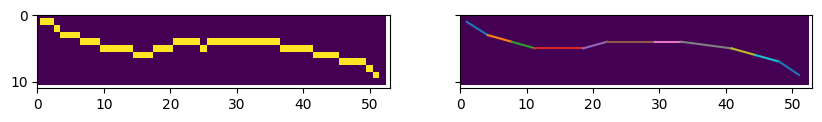

Length: 51.00, Waviness: 0.3581 



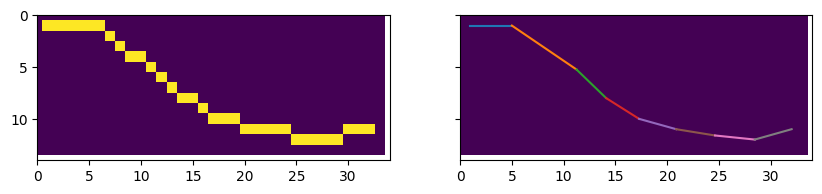

Length: 32.00, Waviness: 0.2944 



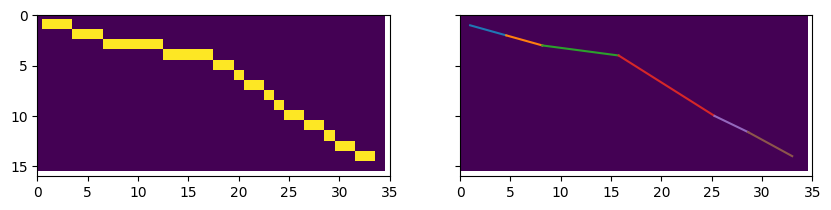

Length: 33.00, Waviness: 0.3244 



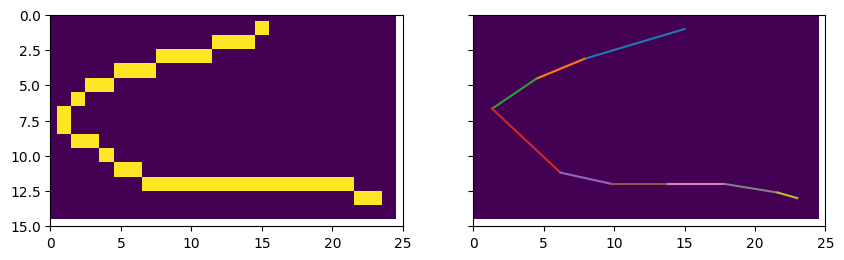

Length: 38.00, Waviness: 0.6141 



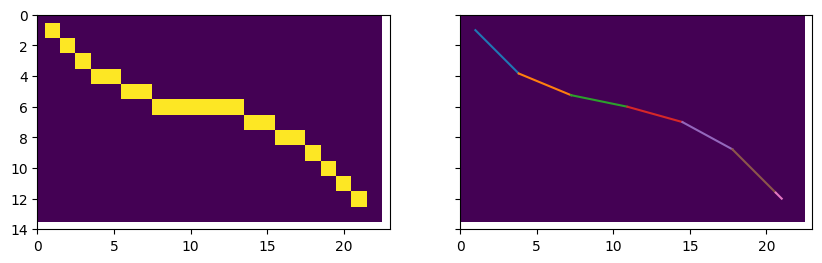

Length: 21.00, Waviness: 0.2859 



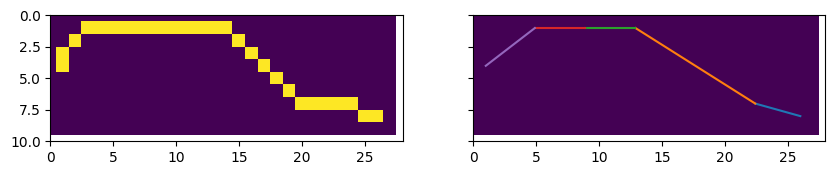

Length: 27.00, Waviness: 0.3620 



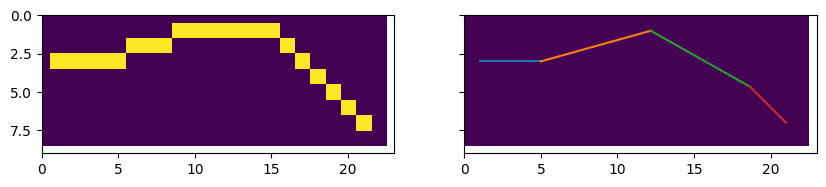

Length: 21.00, Waviness: 0.4715 



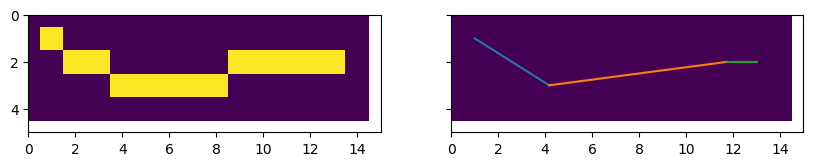

Length: 13.00, Waviness: 0.3504 



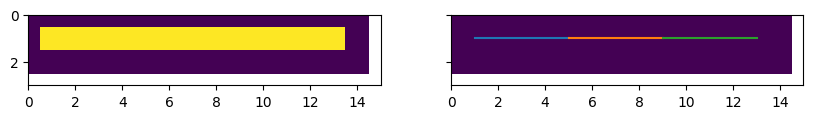

Length: 13.00, Waviness: 0.0000 



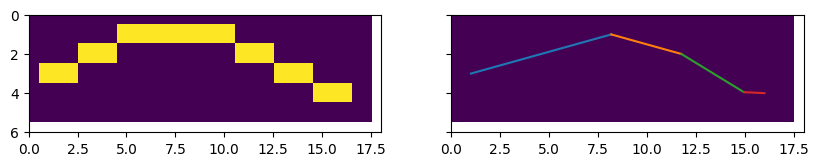

Length: 16.00, Waviness: 0.4160 



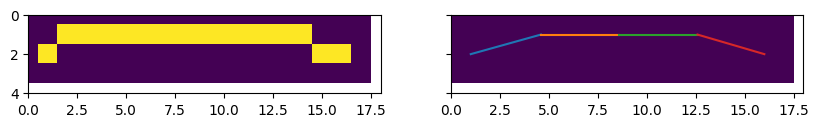

Length: 16.00, Waviness: 0.1440 



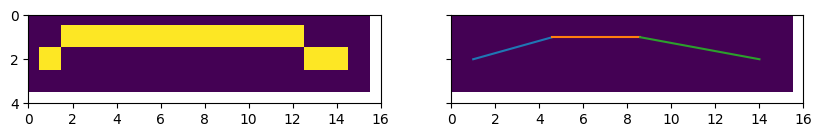

Length: 14.00, Waviness: 0.2231 



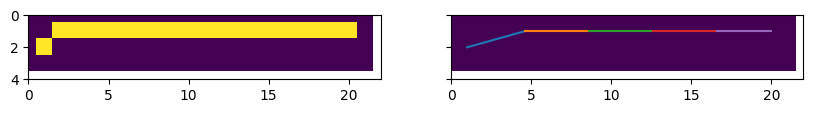

Length: 20.00, Waviness: 0.0514 



In [10]:
for id, region in enumerate(centerline.regions):
    plt.close('all')
    points_dist = lambda pt_0, pt_1: math.sqrt((pt_0.x-pt_1.x)**2 + (pt_0.y-pt_1.y)**2)
    segment_angle = lambda segment: math.atan2((segment.point_1.y-segment.point_0.y), (segment.point_1.x-segment.point_0.x)) # * 180 / math.pi
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
    ax = ax.ravel()
    region_image = np.pad(region.image, (1, 1))
    ax[0].imshow(region_image)
    points = [centerline.Point(point[1] + 1, point[0] + 1) for point in region.coords]
    points = centerline.sort_points(points)
    shape_line = LineString([(point.x, point.y) for point in points])
    seg_length = 4
    num_seg = int(np.ceil(shape_line.length / seg_length))
    split_points = [shape_line.interpolate(i * seg_length) for i in range(1, num_seg)]
    splitter = MultiPoint(split_points)

    if len(splitter.geoms) < 1:
        fragments = [shape_line]
    else:
        fragments = [frag for frag in split(shape_line, splitter).geoms if not frag.is_empty]

    seg_angles = []
    seg_lengths = []
    ax[1].imshow(region_image * 0)
    for fragment in fragments:
        sx, sy = fragment.coords.xy[0][0], fragment.coords.xy[1][0]
        ex, ey = fragment.coords.xy[0][-1], fragment.coords.xy[1][-1]
        seg_angles, seg_lengths, waviness = centerline.single_fiber_feats(fragments)
        ax[1].plot((sx, ex), (sy, ey))

    full_length = region.area
    ax[1].set_xlim((0, region_image.shape[1]))
    ax[1].set_ylim((region_image.shape[0], 0))
    plt.show()
    print(f'Length: {full_length:.2f}, Waviness: {waviness:.4f} \n')